In [4]:
# Copyright 2022 Google LLC
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses /LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# This software is provided as-is, without warranty or representation for any use or purpose. 
# Your use of it is subject to your agreements with Google.”  


# <font color='blue'>Tour of AI/ML on GCP</font>
---
## Inventory
  1. Environment setup
  1. Loading Data into BQ
  1. Dataset exploration with BQ, BQML
  1. Feature store
  1. Explainable AI Model
  1. Vertex Pipeline: custom/AutoML models training, evaluation, and deployment
  


---
---
## 1. Environment Setup </font>
---
### 1.1 Set up your local development environment

**If you are using Colab or Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

---
### 1.2 Install additional packages


In [5]:
import sys

if "google.colab" in sys.modules:
    USER_FLAG = ""
else:
    USER_FLAG = "--user"

In [6]:
!pip3 install {USER_FLAG} google-cloud-aiplatform --upgrade
!pip3 install {USER_FLAG} kfp google-cloud-pipeline-components --upgrade
!pip3 install {USER_FLAG} explainable-ai-sdk --upgrade
!pip3 install {USER_FLAG} kaggle

---
### 1.3 Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [1]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

KFP SDK version: 1.8.13


---
### 1.4 Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. Follow the "**Configuring your project**" instructions from the Vertex Pipelines documentation.

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [110]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  gcp-ml-sandbox


Otherwise, set your project ID here.

In [111]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "python-docs-samples-tests"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [112]:
from datetime import datetime

#TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
TIMESTAMP = '20220913155936'

---
### 1.6 Create a Cloud Storage bucket as necessary

You will need a Cloud Storage bucket for this example.  If you don't have one that you want to use, you can make one now.


Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [113]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "-aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [13]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://gcp-ml-sandbox-aip-20220913155936/...
ServiceException: 409 A Cloud Storage bucket named 'gcp-ml-sandbox-aip-20220913155936' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [6]:
! gsutil ls -al $BUCKET_NAME

  79156935  2022-09-13T16:39:11Z  gs://gcp-ml-sandbox-aip-20220913155936/telecom_churn_data.csv#1663087151150747  metageneration=1
TOTAL: 1 objects, 79156935 bytes (75.49 MiB)


---
### 1.7 Import libraries and define constants

Define some constants. 

In [114]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

USER = "robv"  # <---CHANGE THIS
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

WORKING_DIR = f"{PIPELINE_ROOT}/{TIMESTAMP}"

MODEL_DISPLAY_NAME = f"train_deploy-{TIMESTAMP}"
print(WORKING_DIR, MODEL_DISPLAY_NAME)

env: PATH=/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jupyter/.local/bin
gs://gcp-ml-sandbox-aip-20220913155936/pipeline_root/robv/20220913155936 train_deploy-20220913155936


Do some imports:

In [115]:
import uuid
import numpy as np
import logging
import os
import tensorflow as tf
import pandas as pd
import kfp
import google.auth
import explainable_ai_sdk

from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.cloud.aiplatform import datasets

from google_cloud_pipeline_components import aiplatform as gcc_aip

from google.cloud.aiplatform_v1beta1 import (
    FeaturestoreOnlineServingServiceClient, FeaturestoreServiceClient)
from google.cloud.aiplatform_v1beta1.types import FeatureSelector, IdMatcher
from google.cloud.aiplatform_v1beta1.types import \
    entity_type as entity_type_pb2
from google.cloud.aiplatform_v1beta1.types import feature as feature_pb2
from google.cloud.aiplatform_v1beta1.types import \
    featurestore as featurestore_pb2
from google.cloud.aiplatform_v1beta1.types import \
    featurestore_monitoring as featurestore_monitoring_pb2
from google.cloud.aiplatform_v1beta1.types import \
    featurestore_online_service as featurestore_online_service_pb2
from google.cloud.aiplatform_v1beta1.types import \
    featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1beta1.types import io as io_pb2
from google.protobuf.duration_pb2 import Duration

from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google import experimental
from kfp.v2.google.client import AIPlatformClient
from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, Input, component, Model, Dataset, Artifact, Condition

from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

Set environment variables

In [116]:
API_ENDPOINT = "us-central1-aiplatform.googleapis.com"


## 2. Create & Explore BQ Dataset
### 2.1 Create BQ Dataset

In [10]:
DATASET = 'aiml_day'
!bq --location=us mk --description 'Demo Dataset for AI/ML Day' gcp-ml-sandbox:$DATASET

/usr/lib/google-cloud-sdk/platform/bq/bq.py:41: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
BigQuery error in mk operation: Dataset 'gcp-ml-sandbox:aiml_day' already
exists.


In [11]:
DATASET

'aiml_day'

### 2.2 Load training dataset
1. Download sample dataset from https://www.kaggle.com/ashishkumarsingh123/telecom-churn-dataset
2. Create a new dataset in your GCP BQ instance, and upload the downloaded data to BQ as a new table. e.g.: bq://sample-project.ml_sample.telecom_churn

In [12]:
!kaggle datasets download -d ashishkumarsingh123/telecom-churn-dataset --force
!unzip -o telecom-churn-dataset.zip
output=!(zipinfo -1 telecom-churn-dataset.zip)
FILENAME=output[0]
!gsutil cp $FILENAME $BUCKET_NAME
!bq load --autodetect --replace=true aiml_day.t_telecom_customers_raw $BUCKET_NAME/$FILENAME


 22%|████████▏                             | 5.00M/23.2M [00:00<00:00, 42.4MB/s]
100%|██████████████████████████████████████| 23.2M/23.2M [00:00<00:00, 89.3MB/s]
Archive:  telecom-churn-dataset.zip
  inflating: telecom_churn_data.csv  
Copying file://telecom_churn_data.csv [Content-Type=text/csv]...
- [1 files][ 75.5 MiB/ 75.5 MiB]                                                
Operation completed over 1 objects/75.5 MiB.                                     
/usr/lib/google-cloud-sdk/platform/bq/bq.py:41: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Waiting on bqjob_r1e9a109139262062_000001833db1dc19_1 ... (22s) Current status: DONE   


### 2.3 Review dataset using inline BQ Editor


#@BigQuery
select * from `aiml_day.t_telecom_customers_raw` limit 10

### 2.4 Review dataset using `%%bigquery` magic
Using the `%%bigquery` magic, you can write sql inline in a cell and get the results directly in a dataframe

In [26]:
%%bigquery customer_df
select * from `aiml_day.t_telecom_customers_raw` limit 10

Downloading: 100%|██████████| 10/10 [00:00<00:00, 10.16rows/s]


In [27]:
customer_df

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7001625959,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.00,0.00,4.17,0.0
1,7001204172,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.0
2,7001864400,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,119.518,...,0,NaN,1.0,NaN,NaN,902,0.00,0.00,0.00,0.0
3,7001419799,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,48.570,...,0,NaN,NaN,NaN,NaN,3557,0.00,0.00,0.00,0.0
4,7001654241,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,63.611,...,0,NaN,NaN,NaN,NaN,912,0.00,0.00,0.00,0.0
5,7002070365,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,31.000,...,0,NaN,NaN,NaN,NaN,270,0.00,0.00,0.00,0.0
6,7000875565,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,430.975,...,0,NaN,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0
7,7000187447,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,690.008,...,0,NaN,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0
8,7001678155,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,4.000,...,0,NaN,NaN,NaN,NaN,364,0.00,0.00,0.00,0.0
9,7001028254,109,0,0,0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,271.699,...,0,NaN,NaN,NaN,NaN,3108,1.11,0.22,0.00,0.0


### 2.5 Initial Feature Engineering
Now, let's define our label and drop columns leaking prediction

In [29]:
%%bigquery
# Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount 
# in the first two months (the good phase).

# After filtering the high-value customers, you should get about 29.9k rows.

# Churn:

# Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) 
# AND have not used mobile internet even once in the churn phase. The columns you need to use to tag churners are:

# totalicmou9 totalogmou9 vol2gmb9 vol3gmb9

# After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

CREATE OR REPLACE VIEW `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label` as (
with t as (
  SELECT *, (total_rech_amt_6 + total_rech_amt_7)/2 avg_rech_amt_6_7 FROM `gcp-ml-sandbox.aiml_day.t_telecom_customers_raw`), 
q as (
  select approx_quantiles(avg_rech_amt_6_7, 10)[OFFSET(7)] as q_pct from t),
    
hv as (select if(((total_ic_mou_9 + total_og_mou_9 + vol_2g_mb_9 + vol_3g_mb_9) >0),0,1) is_churned, * from t,q where t.avg_rech_amt_6_7 >= q.q_pct)
select * 
    EXCEPT(q_pct,total_ic_mou_9,total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9,last_date_of_month_9,arpu_9,onnet_mou_9,offnet_mou_9,roam_ic_mou_9, roam_og_mou_9,
loc_og_t2t_mou_9,loc_og_t2f_mou_9,loc_og_t2c_mou_9,loc_og_mou_9,std_og_t2t_mou_9,std_og_t2f_mou_9,std_og_t2c_mou_9,std_og_mou_9, isd_og_mou_9,spl_og_mou_9,og_others_9,
loc_ic_t2t_mou_9,loc_ic_t2f_mou_9,loc_ic_t2m_mou_9,loc_ic_mou_9,std_ic_t2t_mou_9,std_ic_t2m_mou_9,std_ic_t2f_mou_9,std_ic_t2o_mou_9,std_og_t2m_mou_9,loc_og_t2m_mou_9,
std_ic_mou_9,spl_ic_mou_9,isd_ic_mou_9,ic_others_9,total_rech_num_9, total_rech_amt_9,max_rech_amt_9,date_of_last_rech_9,last_day_rch_amt_9, 
date_of_last_rech_data_9,total_rech_data_9,max_rech_data_9,count_rech_2g_9, count_rech_3g_9, av_rech_amt_data_9, arpu_3g_9, arpu_2g_9, night_pck_user_9,monthly_2g_9,
sachet_2g_9,monthly_3g_9, sachet_3g_9,fb_user_9,sep_vbc_3g) 
from hv)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 999.36query/s] 


""


Lets also create a few views which we can use to build our models.  Lets take our labeled data and now split it into training and holdout (eval and prediction) sets

In [32]:
%%bigquery
#-----------------------------------------------
# Split data based on mobile_number
#-----------------------------------------------
CREATE OR REPLACE VIEW `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_split` as
(select *,
CASE
    WHEN MOD(mobile_number, 10) < 8 THEN 'training'
    WHEN MOD(mobile_number, 10) = 8 THEN 'evaluation'
    WHEN MOD(mobile_number, 10) = 9 THEN 'prediction'
  END AS training_split
  FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label`
);

#-----------------------------------------------
# Training data
#-----------------------------------------------
CREATE OR REPLACE VIEW  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_train` as
(select * from gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_split
where training_split = 'training');

#-----------------------------------------------
# Eval holdout
#-----------------------------------------------
CREATE OR REPLACE VIEW  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_eval` as
(select * from gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_split
where training_split = 'evaluation');

#-----------------------------------------------
# Prediction holdout
#-----------------------------------------------
CREATE OR REPLACE VIEW  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_predict` as
(select * from gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_split
where training_split = 'prediction')

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 781.50query/s] 


""


### 2.6 Build Models in BigQuery
Finally lets build a few models in BQML so that we can start to get some ideas about our dataset

(Note: it may be more efficient to run these directly in the BQ console so they can be parallelized, otherwise
Jupyter will block until all the models are complete!)

In [39]:
%%bigquery 

# Create a series of models on training dataset with defaults, explainability enabled

#-----------------------------------------------
# Logistic Regression
#-----------------------------------------------
CREATE OR REPLACE MODEL
  `aiml_day.m_churn_log_reg`
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    input_label_cols=['is_churned'],
    model_registry="vertex_ai",
   vertex_ai_model_id='high_value_customers_churn_log_reg'
  ) AS
SELECT
  * EXCEPT(mobile_number, circle_id, training_split)
FROM
  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_train`;

    
#-----------------------------------------------
# Boosted Tree Classifier
#-----------------------------------------------
CREATE OR REPLACE MODEL
  `aiml_day.m_churn_boosted_tree`
OPTIONS
  ( model_type='BOOSTED_TREE_CLASSIFIER',
    auto_class_weights=TRUE,
    input_label_cols=['is_churned'],
    enable_global_explain=TRUE,
    model_registry="vertex_ai",
    vertex_ai_model_id='high_value_customers_churn_boosted_tree'
  ) AS
SELECT
  * EXCEPT(mobile_number, circle_id, training_split)
FROM
  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_train`;

    
#-----------------------------------------------
# Random Forest Classifier
#-----------------------------------------------
    CREATE OR REPLACE MODEL
  `aiml_day.m_churn_random_forest`
OPTIONS
  ( model_type='RANDOM_FOREST_CLASSIFIER',
    auto_class_weights=TRUE,
    input_label_cols=['is_churned'],
    enable_global_explain=TRUE,
    model_registry="vertex_ai",
    vertex_ai_model_id='high_value_customers_churn_random_forest'
  ) AS
SELECT
  * EXCEPT(mobile_number, circle_id, training_split)
FROM
  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_train`;
    

#-----------------------------------------------
# Deep Neural Network Classifier
#-----------------------------------------------
    CREATE OR REPLACE MODEL
  `aiml_day.m_churn_dnn`
OPTIONS
  ( model_type='DNN_CLASSIFIER',
    auto_class_weights=TRUE,
    input_label_cols=['is_churned'],
    enable_global_explain=TRUE,
    model_registry="vertex_ai",
    vertex_ai_model_id='high_value_customers_churn_dnn'
  ) AS
SELECT
  * EXCEPT(mobile_number, circle_id, training_split)
FROM
  `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_train`


Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 766.22query/s] 


""


We can examine the training info directly from BigQuery to gain some understanding of how our model training went

In [44]:
%%bigquery training_info
select *
from ML.TRAINING_INFO(model `aiml_day.m_churn_boosted_tree`)

Downloading: 100%|██████████| 8/8 [00:01<00:00,  5.10rows/s]


In [45]:
training_info

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,8,0.225761,0.345773,0.3,82
1,0,7,0.242343,0.344071,0.3,59
2,0,6,0.263185,0.354939,0.3,71
3,0,5,0.287952,0.366378,0.3,14080
4,0,4,0.318668,0.385453,0.3,56
5,0,3,0.363992,0.417847,0.3,55
6,0,2,0.430062,0.468609,0.3,46
7,0,1,0.526663,0.546300,0.3,94494


Lets compare model performance at 75% confidence threshold

In [46]:
%%bigquery model_results
#standardSQL
SELECT
  'aiml_day.m_churn_log_reg' as model_name, *
FROM
  ML.EVALUATE(MODEL `aiml_day.m_churn_log_reg`,
    (SELECT
      *
    FROM
      `aiml_day.v_high_value_customers_w_label_eval`
    ),
    STRUCT(0.75 AS threshold)
  )
  UNION ALL
  SELECT
  'aiml_day.m_churn_random_forest' as model_name, *
FROM
  ML.EVALUATE(MODEL `aiml_day.m_churn_random_forest`,
    (SELECT
      *
    FROM
      `aiml_day.v_high_value_customers_w_label_eval`
    ),STRUCT(0.75 AS threshold)
  )
    UNION ALL
  SELECT
  'aiml_day.m_churn_boosted_tree' as model_name, *
FROM
  ML.EVALUATE(MODEL `aiml_day.m_churn_boosted_tree`,
    (SELECT
      *
    FROM
      `aiml_day.v_high_value_customers_w_label_eval`
    ),STRUCT(0.75 AS threshold)
  )
    UNION ALL
  SELECT
  'aiml_day.m_churn_dnn' as model_name, *
FROM
  ML.EVALUATE(MODEL `gcp-ml-sandbox.aiml_day.m_churn_dnn`,
    (SELECT
      *
    FROM
      `aiml_day.v_high_value_customers_w_label_eval`
    ),STRUCT(0.75 AS threshold)
  )



Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.66rows/s]


In [54]:
model_results

,model_name,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,aiml_day.m_churn_boosted_tree,0.585774,0.619469,0.939877,0.602151,0.283943,0.928399
1,aiml_day.m_churn_dnn,0.363083,0.792035,0.882678,0.497914,0.486419,0.912907
2,aiml_day.m_churn_log_reg,0.463687,0.367257,0.922327,0.409877,0.483815,0.886547
3,aiml_day.m_churn_random_forest,0.578947,0.146018,0.929477,0.233216,0.245140,0.936860


<AxesSubplot:ylabel='model_name'>

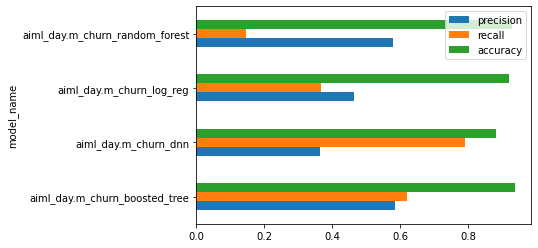

In [55]:
model_results
model_results.plot.barh(x='model_name',y=['precision','recall','accuracy'])

### _Toggle to BQ console, explore in more detail_

In [43]:
#Update description and models in Vertex

suffixes = ['log reg','boosted tree', 'random forest', 'dnn']
for s in suffixes:
    model_name = 'high_value_customers_churn_{}'.format(s.replace(' ','_'))
    m = aiplatform.Model(model_name=model_name)
    m.update( description=f"Churn model using {s}", labels={'aiml_day': 'True'}, )
    print('Model: ',m)

Model:  <google.cloud.aiplatform.models.Model object at 0x7f79b1c95c10> 
resource name: projects/357746845324/locations/us-central1/models/high_value_customers_churn_log_reg
Model:  <google.cloud.aiplatform.models.Model object at 0x7f79b18b9ed0> 
resource name: projects/357746845324/locations/us-central1/models/high_value_customers_churn_boosted_tree
Model:  <google.cloud.aiplatform.models.Model object at 0x7f79b1c62dd0> 
resource name: projects/357746845324/locations/us-central1/models/high_value_customers_churn_random_forest
Model:  <google.cloud.aiplatform.models.Model object at 0x7f79b1b823d0> 
resource name: projects/357746845324/locations/us-central1/models/high_value_customers_churn_dnn


## 3. Feature Store Creation



### 3.1 Create Feature store

In [16]:
# Create admin_client for CRUD and data_client for reading feature values.
admin_client = FeaturestoreServiceClient(client_options={"api_endpoint": API_ENDPOINT})
data_client = FeaturestoreOnlineServingServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

# Represents featurestore resource path.
BASE_RESOURCE_PATH = admin_client.common_location_path(PROJECT_ID, REGION)

creds,_ = google.auth.default()

FEATURESTORE_ID_TO_CREATE = "telco_churn_prediction_{timestamp}".format(timestamp=TIMESTAMP)

# Use AI Platform SDK to create Feature Store
aiplatform.init(credentials=creds)

fs = aiplatform.Featurestore.create(
        featurestore_id=FEATURESTORE_ID_TO_CREATE,
        online_store_fixed_node_count=1,
        sync=True,
    )
fs.wait()

Creating Featurestore
Create Featurestore backing LRO: projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/operations/8379787477203812352
Featurestore created. Resource name: projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936
To use this Featurestore in another session:
featurestore = aiplatform.Featurestore('projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936')


In [149]:
FEATURESTORE_ID_TO_CREATE = "telco_churn_prediction_{timestamp}".format(timestamp=TIMESTAMP)
FEATURESTORE_ID_TO_CREATE

'telco_churn_prediction_20220913155936'

---
### 3.2 Create Entity Type
You can specify a monitoring config which will by default be inherited by all Features under this EntityType.

In [21]:
# Create users entity type with monitoring enabled.
# All Features belonging to this EntityType will by default inherit the monitoring config.
users_entity_type_lro = admin_client.create_entity_type(
    featurestore_service_pb2.CreateEntityTypeRequest(
        parent=admin_client.featurestore_path(PROJECT_ID, REGION, FEATURESTORE_ID_TO_CREATE),
        entity_type_id="users",
        entity_type=entity_type_pb2.EntityType(
            description="Users entity",
            monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                    monitoring_interval=Duration(seconds=86400),  # 1 day
                ),
                import_features_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.ImportFeaturesAnalysis(
                    state=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.ImportFeaturesAnalysis.State.ENABLED,
                    anomaly_detection_baseline=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.ImportFeaturesAnalysis.Baseline.LATEST_STATS
                ),
            ),
        ),
    )
)

# Similarly, wait for EntityType creation operation.
print(users_entity_type_lro.result())

name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users"



### 3.3 Identify the most import model features
Create features based on superset of top 10 columns from Boosted Trees Feature Importance (BT Importance Gain & Explainability Feature Attribution)


In [58]:
%%bigquery important_features
SELECT
  *
FROM (
  SELECT
    feature
  FROM (
    SELECT
      feature, RANk() over(order by attribution desc) as RANK
    FROM
      ML.GLOBAL_EXPLAIN(MODEL `gcp-ml-sandbox.aiml_day.m_churn_boosted_tree`,
        STRUCT(TRUE AS class_level_explain))
  )
  WHERE RANK <=10)
UNION DISTINCT
SELECT
  *
FROM (
  SELECT
    feature
  FROM (
    SELECT
      feature, RANK() OVER(order by importance_gain desc) AS RANK
    FROM
      ML.FEATURE_IMPORTANCE(MODEL `gcp-ml-sandbox.aiml_day.m_churn_boosted_tree`)

  )WHERE rank <=10
) order by feature


Downloading: 100%|██████████| 12/12 [00:01<00:00,  7.79rows/s]


In [59]:
important_features

,feature
0,count_rech_2g_6
1,date_of_last_rech_8
2,fb_user_8
3,last_day_rch_amt_8
4,loc_og_mou_8
5,loc_og_t2f_mou_8
6,roam_og_mou_8
7,spl_ic_mou_8
8,std_og_mou_7
9,total_ic_mou_8


Now lets create a new table that just has our selected features
TODO - Check on whether or not Feature Store can import from a view

In [185]:
%%bigquery
CREATE OR REPLACE TABLE `aiml_day.t_high_value_customers_w_label_selected_features` as (SELECT cast(mobile_number as string) mobile_number,
    ifnull(count_rech_2g_6,0) count_rech_2g_1,
    ifnull(fb_user_8,0) fb_user_3,
    ifnull(last_day_rch_amt_8,0) last_day_rch_amt_3,
    ifnull(loc_og_mou_8,0) loc_og_mou_3,
    ifnull(loc_og_t2f_mou_8,0) loc_og_t2f_mou_3,
    ifnull(roam_og_mou_8,0) roam_og_mou_3,
    ifnull(spl_ic_mou_8,0) spl_ic_mou_3,
    ifnull(std_og_mou_7,0) std_og_mou_2,
    ifnull(total_ic_mou_8,0) total_ic_mou_3,
    ifnull(total_rech_amt_8,0) total_rech_amt_3,
    ifnull(total_rech_num_7,0) total_rech_num_2,
    is_churned,
    CURRENT_TIMESTAMP() as update_time
    FROM `aiml_day.v_high_value_customers_w_label`)

Query complete after 0.00s: 100%|██████████| 6/6 [00:00<00:00, 3620.46query/s]                        


""



---
### 3.4 Create Feature Type

You can also set a custom monitoring configuration at the Feature level, and view the properties and metrics in the console: sample [properties](https://storage.googleapis.com/cloud-samples-data/ai-platform-unified/datasets/featurestore/Feature%20Properties.png), sample [metrics](https://storage.googleapis.com/cloud-samples-data/ai-platform-unified/datasets/featurestore/Feature%20Snapshot%20Distribution.png).

In [62]:
# Create features for the 'users' entity.
admin_client.batch_create_features(
    parent=admin_client.entity_type_path(PROJECT_ID, REGION, FEATURESTORE_ID_TO_CREATE, "users"),
    requests=[
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="mobile number",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="mobile_number",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="# of times 2g data recharged in first month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="count_rech_2g_1",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.BOOL,
                description="used Facebook in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="fb_user_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="last day amount recharged on third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="last_day_rch_amt_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="local minutes of usage - outgoing in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="loc_og_mou_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="local outgoing minutes of usage - telco to fixed line - in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="loc_og_t2f_mou_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="roaming outgoing minutes of use in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="roam_og_mou_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="special calls incoming minutes of use in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="spl_ic_mou_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="standard outgoing minutes of use in second month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="std_og_mou_2",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.DOUBLE,
                description="total incoming minutes of use in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="total_ic_mou_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="total recharge amount in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="total_rech_amt_3",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.INT64,
                description="total number of times recharged in third month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="total_rech_num_2",
        ),
        featurestore_service_pb2.CreateFeatureRequest(
            feature=feature_pb2.Feature(
                value_type=feature_pb2.Feature.ValueType.BOOL,
                description="Whether or not the user churned.  Based off of cumulative spend, data usage, and minutes of usage in fourth month",
                monitoring_config=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig(
                    snapshot_analysis=featurestore_monitoring_pb2.FeaturestoreMonitoringConfig.SnapshotAnalysis(
                        disabled=False,
                    ),
                ),
            ),
            feature_id="is_churned",
        ),
    ],
).result()

features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/mobile_number"
}
features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/count_rech_2g_1"
}
features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/fb_user_3"
}
features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/last_day_rch_amt_3"
}
features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/loc_og_mou_3"
}
features {
  name: "projects/357746845324/locations/us-central1/featurestores/telco_churn_prediction_20220913155936/entityTypes/users/features/loc_og_t2f_mou_3"
}
features {
  name: "projects/357746

### 3.5 Feature Importing
Import processed features into feature store


In [63]:
BQ_RAW_DATA = "bq://gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label"
FEATURE_DESTINATION = "bq://gcp-ml-sandbox.aiml_day.t_high_value_customers_w_label_selected_features"

In [64]:
FEATURE_DESTINATION

'bq://gcp-ml-sandbox.aiml_day.t_high_value_customers_w_label_selected_features'

In [ ]:
# Create admin_client for CRUD and data_client for reading feature values.
admin_client = FeaturestoreServiceClient(client_options={"api_endpoint": API_ENDPOINT})
data_client = FeaturestoreOnlineServingServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

# Represents featurestore resource path.
BASE_RESOURCE_PATH = admin_client.common_location_path(PROJECT_ID, REGION)
import_users_request = featurestore_service_pb2.ImportFeatureValuesRequest(
    entity_type=admin_client.entity_type_path(
        PROJECT_ID, REGION, FEATURESTORE_ID_TO_CREATE, "users"
    ),
    bigquery_source=io_pb2.BigQuerySource(
        # Source
        input_uri=FEATURE_DESTINATION
    ),
    entity_id_field="mobile_number",
    feature_specs=[
        # Features
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="count_rech_2g_1", source_field="count_rech_2g_1"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="fb_user_3", source_field="fb_user_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="last_day_rch_amt_3", source_field="last_day_rch_amt_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="loc_og_mou_3", source_field="loc_og_mou_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="loc_og_t2f_mou_3", source_field="loc_og_t2f_mou_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="roam_og_mou_3", source_field="roam_og_mou_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="spl_ic_mou_3", source_field="spl_ic_mou_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="std_og_mou_2", source_field="std_og_mou_2"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="total_ic_mou_3", source_field="total_ic_mou_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="total_rech_amt_3", source_field="total_rech_amt_3"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="total_rech_num_2", source_field="total_rech_num_2"),
        featurestore_service_pb2.ImportFeatureValuesRequest.FeatureSpec(id="is_churned", source_field="is_churned")
    ],
    feature_time_field="update_time",
    worker_count=10,
)
ingestion_lro = admin_client.import_feature_values(import_users_request)
ingestion_lro.result()

In [400]:
print(FEATURE_DESTINATION)

bq://gcp-ml-sandbox.aiml_day.t_high_value_customers_w_label_selected_features


---
## 4. Train an Explainable ML Model
Now, lets train a customized model with tensorflow, and explain it with explainable AI SDK

### 4.1 Serve training data from feature store
First, we are going to start by demonstrating how to use the feature store to create a dataset for training.  To do this we are doing the following
1. Grab a list of mobile ids (our user entity identifier) that we want to grab from the feature store along with a timestamp value for which we want to select the attributes.  Export this to a CSV
2. Call the feature store service and specify the IDs to grab from the feature store for the given period of time.
3. Tell feature store to export that data to a new dataset we can use for training.  Note we are telling Feature Store to grab all the features for the user entity, but we could filter that by using the ID Selector.

In [125]:
# Grab Mobile IDs and generate timestamp
TRAINING_DATA_TABLE = '{}.aiml_day.t_telecom_high_value_customers_from_feature_store'.format(PROJECT_ID)
FEATURESTORE_ID = '' # fill in or leave empty if you just created the feature store
if FEATURESTORE_ID == '':
    FEATURESTORE_ID = FEATURESTORE_ID_TO_CREATE
TRAINING_DATA_SELECTOR_LOC = BUCKET_NAME + '/dataset/query_instance_2.csv'


In [ ]:



# Read the user identifiers and dump them to a CSV with current timestamp
bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()
query_string = """
SELECT
    mobile_number
FROM `{}`
""".format(BQ_RAW_DATA.split('/')[-1])

user_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

X_train = user_df['mobile_number']

now = datetime.now()
current_time = now.strftime("%Y-%m-%dT%H:%M:%SZ")
res = pd.DataFrame()
res['users']  = X_train
res['timestamp'] = current_time
res.to_csv(TRAINING_DATA_SELECTOR_LOC, index=False)


# Use Mobile Ids to grab Features
admin_client = FeaturestoreServiceClient(client_options={"api_endpoint": API_ENDPOINT})
batch_serving_request = featurestore_service_pb2.BatchReadFeatureValuesRequest(
    # featurestore info
    featurestore=admin_client.featurestore_path(PROJECT_ID, REGION, FEATURESTORE_ID),
    # URL for the label data, i.e., Table 1.
    csv_read_instances=io_pb2.CsvSource(
        gcs_source=io_pb2.GcsSource(uris=[TRAINING_DATA_SELECTOR_LOC])
    ),
    destination=featurestore_service_pb2.FeatureValueDestination(
        bigquery_destination=io_pb2.BigQueryDestination(
            # Output to BigQuery table created earlier
            output_uri='bq://'+TRAINING_DATA_TABLE
        )
    ),
    entity_type_specs=[
        featurestore_service_pb2.BatchReadFeatureValuesRequest.EntityTypeSpec(
            entity_type_id="users",
            feature_selector=FeatureSelector(
                id_matcher=IdMatcher(
                    ids=['*'
                    ]
                )
            ),
        ),
    ],
)
batch_serving_lro = admin_client.batch_read_feature_values(batch_serving_request)
batch_serving_lro.result()

### 4.1 Grab the training data

Grab the training data that was output from the Feature Store

In [117]:
CUSTOM_MODEL_DIR = '{}/sample_model/'.format(BUCKET_NAME)
TENSORBOARD_LOG_DIR = '{}/tensorboard_log_dir/'.format(BUCKET_NAME)
model_dir = CUSTOM_MODEL_DIR
table_id = TRAINING_DATA_TABLE

bqclient = bigquery.Client(PROJECT_ID)
bqstorageclient = bigquery_storage.BigQueryReadClient()

query_string = """
SELECT
  *
FROM `{}`
""".format(table_id)
logging.info('loading training data')
df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
logging.info('training data loaded');
df.head()

NameError: name 'TRAINING_DATA_TABLE' is not defined

#### 4.1.1 UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [118]:
import random
import string


# Generate a uuid of length 8
def generate_uuid():
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=8))


UUID = generate_uuid()

### 4.2 Set hardware accelerators

You can set hardware accelerators for both training and prediction.

Set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Tesla K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

Otherwise specify `(None, None)` to use a container image to run on a CPU.

Learn [which accelerators are available in your region.](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators)

In [119]:
TRAIN_GPU, TRAIN_NGPU = (aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_T4, 1)

DEPLOY_GPU, DEPLOY_NGPU = (aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_T4, 1)

### 4.3 Set pre-built containers

Vertex AI provides pre-built containers to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [126]:
TRAIN_VERSION = "tf-gpu.2-8"
DEPLOY_VERSION = "tf2-gpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_T4 1
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_T4 1


### 4.4 Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

Learn [which machine types are available for training](https://cloud.google.com/vertex-ai/docs/training/configure-compute) and [which machine types are available for prediction](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute)

In [127]:
MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type n1-standard-4
Deploy machine type n1-standard-4


### 4.5 Choosing a training image 

There are two ways you can train a model using a container image:

- **Use a Vertex AI pre-built container**. If you use a pre-built training container, you must additionally specify a Python package to install into the container image. This Python package contains your training code.

- **Use your own custom container image**. If you use your own container, the container image must contain your training code.

### 4.6 Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they are:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--batch_size=" + BATCH_SIZE`: The number of batch size for training.
  - `"--distribute=" + TRAIN_STRATEGY` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

In [128]:
JOB_NAME = "high_value_customers_churn_selected_features_custom_job_" + UUID

if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"

EPOCHS = 1
BATCH_SIZE = 500

TENSORBOARD= '1288152638730272768'
TENSORBOARD_PATH = f'projects/{PROJECT_ID}/locations/{REGION}/tensorboards/{TENSORBOARD}'
SERVICE_ACCOUNT='357746845324-compute@developer.gserviceaccount.com'

CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--batch_size=" + str(BATCH_SIZE),
    "--distribute=" + TRAIN_STRATEGY,
    "--training_data_uri=" + TRAINING_DATA_TABLE
]

#### 4.6.1 Training script

In the next cell, write the contents of the training script, `task.py`. In summary, the script does the following:

- Loads the data from the BigQuery table using the BigQuery Python client library.
- Loads the pre-calculated mean and standard deviation from the Cloud Storage bucket.
- Builds a model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and batch size according to the arguments `args.epochs` and `args.batch_size`
- Gets the directory where to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is [set by the training service](https://cloud.google.com/vertex-ai/docs/training/code-requirements#environment-variables).
- Saves the trained model to the model directory.

In [ ]:
%%writefile task_v5.py

import argparse
import tensorflow as tf
import numpy as np
import os

import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from google.cloud import storage

import hypertune



# Read args
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', dest='epochs',
                    default=1, type=int,
                    help='Number of epochs.')
parser.add_argument('--batch_size', dest='batch_size',
                    default=10, type=int,
                    help='Batch size.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='Distributed training strategy.')

parser.add_argument('--training_data_uri', dest='training_data_uri', type=str, default='gcp-ml-sandbox.aiml_day.t_telecom_high_value_customers_from_feature_store',
                    help='BQ input training URI')

parser.add_argument(
      '--learning_rate',
      type=float,
      default=.001,
      help='learning rate')
parser.add_argument(
    '--num_units',
    type=int,
    default=25,
    help='number of units in last hidden layer')

args = parser.parse_args()

# Grab BQ Source
training_data_uri = args.training_data_uri

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Set up training variables
LABEL_COLUMN = "is_churned"
UNUSED_COLUMNS = ['mobile_number','timestamp','entity_type_users']
NA_VALUES = ["NA", "."]



# Set up BigQuery clients
bqclient = bigquery.Client()

# Download a table
def download_table(bq_table_uri: str):
    # Remove bq:// prefix if present
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix):]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(
        table,
    )
    return rows.to_dataframe(create_bqstorage_client=False)

def preprocess(df):
    """Converts categorical features to numeric. Removes unused columns.

    Args:
      df: Pandas df with raw data

    Returns:
      df with preprocessed data
    """
    df = df.drop(columns=UNUSED_COLUMNS)

    # Drop rows with NaN's
    df = df.dropna()

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = df.select_dtypes(["int32", "float32", "float64","bool"]).columns
    df[numeric_columns] = df[numeric_columns].astype("float32")

    return df

def convert_dataframe_to_dataset(df_train):
    df_train = preprocess(df_train)

    df_train_x, df_train_y = df_train, df_train.pop(LABEL_COLUMN)

    y_train = np.asarray(df_train_y).astype("float32")

    # Convert to numpy representation
    x_train = np.asarray(df_train_x)

    dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    return (dataset_train)

def create_model(num_features):
    # Create model
    Dense = tf.keras.layers.Dense
    model = tf.keras.Sequential(
        [
            Dense(
                100,
                activation=tf.nn.relu,
                kernel_initializer="uniform",
                input_dim=num_features,
            ),
            Dense(75, activation=tf.nn.relu),
            Dense(50, activation=tf.nn.relu),
            Dense(args.num_units, activation=tf.nn.relu),
            Dense(1, activation='sigmoid'),
            #Dense(2,activation='softmax')
        ]
    )
    
    # Compile Keras model
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate,clipnorm=1.0)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC(curve='PR')], optimizer=optimizer
    )
    
    return model

# Main Logic
df_train = download_table(training_data_uri) # Good

dataset_train = convert_dataframe_to_dataset(df_train)

# Shuffle train set
dataset_train = dataset_train.shuffle(len(df_train))

# Create the model
with strategy.scope():
    model = create_model(num_features=dataset_train._flat_shapes[0].dims[0].value)
    
# Add TB Callback:
log_dir = "logs"
if 'AIP_TENSORBOARD_LOG_DIR' in os.environ:
    log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR']
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      histogram_freq=1)

# Set up datasets
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = args.batch_size * NUM_WORKERS
dataset_train = dataset_train.batch(GLOBAL_BATCH_SIZE)

# Train the model
history = model.fit(dataset_train, epochs=args.epochs,callbacks=[tensorboard_callback])

# DEFINE METRIC
hp_metric = history.history['auc'][-1]

hpt = hypertune.HyperTune()
hpt.report_hyperparameter_tuning_metric(
  hyperparameter_metric_tag='auc',
  metric_value=hp_metric,
  global_step=args.epochs)

# Customize the serving signature to handle an instance key & key/value pairs:
## Setup input tensors:
COLUMN_NAMES = ["std_og_mou_2",
        "loc_og_mou_3",
        "fb_user_3",
        "total_rech_amt_3",
        "roam_og_mou_3",
        "count_rech_2g_1",
        "total_ic_mou_3",
        "loc_og_t2f_mou_3",
        "last_day_rch_amt_3",
        "total_rech_num_2",
        "spl_ic_mou_3"
]

input_sig = []

for col_name in COLUMN_NAMES:
    input_sig.append(tf.TensorSpec([None], dtype=tf.float32,name=col_name))
                     
# Mobile # = instance key
input_sig.append(tf.TensorSpec([None], dtype=tf.string,name='mobile_number'))
print(input_sig)    
    
@tf.function(input_signature=[input_sig])
def keyed_prediction(key_plus_features):
    import copy
    
    kpf = key_plus_features.copy() # Make a copy
    key = kpf.pop()
    
    #Stack and transpose
    features = tf.stack(kpf,0)
    features = tf.reshape(features, (-1,len(COLUMN_NAMES))
    
    #Generate predictions - concat probs for classification eval
    pred = model(features, training=False)
    inv = 1- pred
    combined = tf.concat([pred,inv],1)
    
    #Setup labels
    labels = tf.constant([['will_churn','will_not_churn']])
    batch_size = tf.shape(pred)[0]
    batch_labels = tf.tile(labels,[batch_size,1])
    return {
        'churn_probability':combined,
        'classes':batch_labels,
        'mobile_number': key
    }


if not os.getenv("AIP_MODEL_DIR"):
    model_dir = 'model'
else:
    model_dir = os.getenv("AIP_MODEL_DIR")
tf.saved_model.save(model, model_dir, signatures={'serving_default': keyed_prediction})

In [100]:
pred= [[1],[2],[3]]
batch_size = tf.shape(pred)[0]
labels = tf.constant([['will_churn','will_not_churn']])
classes = tf.tile(labels,[batch_size,1])
print(classes)

tf.Tensor(
[[b'will_churn' b'will_not_churn']
 [b'will_churn' b'will_not_churn']
 [b'will_churn' b'will_not_churn']], shape=(3, 2), dtype=string)


In [138]:
#local testing
!curl -d @instances.json -X POST http://localhost:8501/v1/models/churn:predict

curl: (52) Empty reply from server


In [13]:
#local testing
!curl -d @instances.json -X POST http://localhost:8501/v1/models/churn:predict

{
    "predictions": [
        {
            "churn_probability": 9.16966383e-05,
            "mobile_number": "7000721289",
            "inv": 0.999908328
        },
        {
            "churn_probability": 0.00106868183,
            "mobile_number": "7000721289",
            "inv": 0.998931289
        }
    ]
}

In [61]:
import tensorflow as tf
pred = [[.3],[.2]]
inv = [[.7],[.8]]
extra =[[1],[2]]
new = tf.concat([pred, inv,extra],0)
#print(new)
print(tf.shape(new)[0])

tf.Tensor(6, shape=(), dtype=int32)


### 4.7 Train the model

Define your custom `TrainingPipeline` on Vertex AI.

Use the `CustomTrainingJob` class to define the `TrainingPipeline`. The class takes the following parameters:

- `display_name`: The user-defined name of this training pipeline.
- `script_path`: The local path to the training script.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model — either a pre-built container or a custom container.

Use the `run` function to start training. The function takes the following parameters:

- `args`: The command line arguments to be passed to the Python script.
- `replica_count`: The number of worker replicas.
- `model_display_name`: The display name of the `Model` if the script produces a managed `Model`.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.

The `run` function creates a training pipeline that trains and creates a `Model` object. After the training pipeline completes, the `run` function returns the `Model` object.

In [130]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task_v5.py",
    container_uri=TRAIN_IMAGE,
    requirements=["google-cloud-bigquery>=2.20.0", "db-dtypes"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
    staging_bucket=BUCKET_NAME,

)

MODEL_DISPLAY_NAME = "high_value_customers_churn_selected_features_keyed_predictions_v5"

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
        tensorboard=TENSORBOARD_PATH,
        service_account=SERVICE_ACCOUNT,
        enable_web_access=True
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_count=0,
        tensorboard=TENSORBOARD_PATH,        
        service_account=SERVICE_ACCOUNT,
        enable_web_access=True

    )

Training script copied to:
gs://gcp-ml-sandbox-aip-20220913155936/aiplatform-2022-10-05-21:35:23.207-aiplatform_custom_trainer_script-0.1.tar.gz.
Training Output directory:
gs://gcp-ml-sandbox-aip-20220913155936/aiplatform-custom-training-2022-10-05-21:35:23.415 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4154619859394625536?project=357746845324
CustomTrainingJob projects/357746845324/locations/us-central1/trainingPipelines/4154619859394625536 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1036941444696244224?project=357746845324
View tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+gcp-ml-sandbox+locations+us-central1+tensorboards+1288152638730272768+experiments+1036941444696244224
CustomTrainingJob projects/357746845324/locations/us-central1/trainingPipelines/4154619859394625536 current state:
P

#### 4.7.1 Vertex Experiments and Managed Tensorboard
Since we passed the path to a Managed Tensorboard instance for our `CustomTrainingJob`, we can now examine the training process without having to install and run Tensorboard locally

### 4.8 Hyperparameter tuning
After our initial experimentation with model training, lets now run a hyperparameter tuning job and vary some specifics how we train our model to see if we can improve model performance


In [431]:
#Maximize PR-AUC and vary the following parameters
from google.cloud.aiplatform import hyperparameter_tuning as hpt

metric_spec = {"auc": "maximize"}

parameter_spec = {
    "learning_rate": hpt.DoubleParameterSpec(min=0.001, max=1, scale="log"),
    "epoch": hpt.IntegerParameterSpec(min=100, max=1000, scale="linear"),
    "batch_size": hpt.IntegerParameterSpec(min=200, max=5000, scale="linear"),
    "num_units": hpt.DiscreteParameterSpec(values=[25, 50, 100], scale=None),
}

In [432]:
#Use the prior configured custom job and now use it to kickoff a HPT tuning job

hpt_custom_job = aiplatform.CustomJob.from_local_script(
    display_name=JOB_NAME,
    script_path="task_v5.py",
    container_uri=TRAIN_IMAGE,
    requirements=["google-cloud-bigquery>=2.20.0", "db-dtypes"],
    staging_bucket=BUCKET_NAME,
    replica_count=1,
    machine_type=TRAIN_COMPUTE,
    accelerator_type=TRAIN_GPU.name,
    accelerator_count=TRAIN_NGPU
    
)

hp_job = aiplatform.HyperparameterTuningJob(
    display_name=f"{JOB_NAME}_hpt_job",
    custom_job=hpt_custom_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=100,
    parallel_trial_count=5,
    project=PROJECT_ID,
    search_algorithm=None
)

hp_job.run()

Training script copied to:
gs://gcp-ml-sandbox-aip-20220913155936/aiplatform-2022-10-19-00:07:29.273-aiplatform_custom_trainer_script-0.1.tar.gz.
Creating HyperparameterTuningJob
HyperparameterTuningJob created. Resource name: projects/357746845324/locations/us-central1/hyperparameterTuningJobs/2205082389254766592
To use this HyperparameterTuningJob in another session:
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/357746845324/locations/us-central1/hyperparameterTuningJobs/2205082389254766592')
View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2205082389254766592?project=357746845324
HyperparameterTuningJob projects/357746845324/locations/us-central1/hyperparameterTuningJobs/2205082389254766592 current state:
JobState.JOB_STATE_PENDING
HyperparameterTuningJob projects/357746845324/locations/us-central1/hyperparameterTuningJobs/2205082389254766592 current state:
JobState.JOB_STATE_RUNNING
HyperparameterTuningJob projec

KeyboardInterrupt: 

Now let's get some detail on the best hyperparameter tuning trial

In [531]:
import google.cloud.aiplatform as aiplatform
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/357746845324/locations/us-central1/hyperparameterTuningJobs/2205082389254766592')
best = (None, None, None, None, 0.0)
for trial in hpt_job.trials:
    # Keep track of the best outcome
    if float(trial.final_measurement.metrics[0].value) > best[4]:
        try:
            best = (
                trial.id,
                int(trial.parameters[0].value),
                int(trial.parameters[1].value),
                float(trial.parameters[2].value),
                float(trial.final_measurement.metrics[0].value),
            )
        except:
            best = (
                trial.id,
                float(trial.parameters[0].value),
                None,
                float(trial.final_measurement.metrics[0].value),
            )

print(f'Best trial: auPRC = {best[4]}')
print(f"Trial id:{best[0]}, batch_size: {best[1]}, epochs: {best[2]}, learning_rate: {best[3]}")

Best trial: auPRC = 0.980094313621521
Trial id:98, batch_size: 1384, epochs: 1000, learning_rate: 0.001


### 4.9 Configure Explanations
For the model we previously trained, lets create some explanation metadata that we can specify when we are deploying our model as well as some parameters around how to generate explanations

In [133]:
# Explanation when using key/value pairs

EXPLANATION_METADATA = {
  "outputs": {
    "churn_probability": {
      "output_tensor_name": "churn_probability"
    }
  },
  "inputs": {
    "std_og_mou_2": {},
    "loc_og_mou_3": {},
    "fb_user_3": {},
    "total_rech_amt_3": {},
    "roam_og_mou_3": {},
    "count_rech_2g_1": {},
    "total_ic_mou_3": {},
    "loc_og_t2f_mou_3": {},
    "last_day_rch_amt_3": {},
    "total_rech_num_2": {},
    "spl_ic_mou_3": {}
    }
  }


EXPLANATION_PARAMS = {"sampled_shapley_attribution": {"path_count": 15}}


### 4.10 Create Model Evaluation
WIP:
* eval job includes data splitter, is this really necessary - we can pre-split should we so choose as long as we provide the join keys post batch prediction
* we can manually create the batch prediction job and grab the output or emulate batch prediction with our endpoint
* Generate the metrics for the classifier - pipeline job
* Import the evaluation - pipeline step


In [504]:
from google.cloud.bigquery import Client, QueryJobConfig
from google.cloud import aiplatform
import pandas as pd
import time
import json


# NOTE: We are goign to output our evaluatiomn data in three different formats - one with GT included, one with no GT (usable by batch prediction if desired) and one with just GT and the instance key
EVAL_FILE_FULL_OUTPUT = 'high_value_customers_eval_full_output.jsonl'
EVAL_FILE_NO_GT_OUTPUT = 'high_value_customers_eval_no_gt_output.jsonl'
GROUND_TRUTH_OUTPUT = 'high_value_customers_eval_gt.jsonl'

endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/6109981717504720896')
client = Client()

query = """SELECT CAST(mobile_number as STRING) as mobile_number,
        ifnull(std_og_mou_7,0) as std_og_mou_2,
        ifnull(loc_og_mou_8,0) as loc_og_mou_3,
        CAST(ifnull(fb_user_8,0) as INT) as fb_user_3,
        ifnull(total_rech_amt_8,0) as total_rech_amt_3,
        (ifnull(roam_og_mou_8,0) + 0) as roam_og_mou_3,
        ifnull(count_rech_2g_6,0) as count_rech_2g_1,
        ifnull(total_ic_mou_8,0) as total_ic_mou_3,
        ifnull(loc_og_t2f_mou_8,0) as loc_og_t2f_mou_3,
        ifnull(last_day_rch_amt_8,0) as last_day_rch_amt_3,
        ifnull(total_rech_num_7,0) as total_rech_num_2,
        ifnull(spl_ic_mou_8,0) as spl_ic_mou_3,
        1 - (CAST(is_churned as INT)) as is_churned
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_eval`"""
job = client.query(query)

df = job.to_dataframe()
full_data = df.to_dict(orient='records')

with open(EVAL_FILE_FULL_OUTPUT, 'w') as f:
    for row in full_data:
        json.dump(row,f)
        f.write('\n')

predict_df = df.copy()
ground_truth_df = pd.DataFrame()
predicted_output_df = pd.DataFrame(columns = ['will_churn','will_not_churn'])

ground_truth_df['is_churned'] = predict_df.pop('is_churned')
ground_truth_df['mobile_number'] = predict_df['mobile_number']

with open(EVAL_FILE_NO_GT_OUTPUT, 'w') as f:
    eval_data = predict_df.to_dict(orient='records')
    for row in eval_data:
        prediction = endpoint.predict([row])
        output= {"instance":row, "prediction":prediction[0][0]}
        predicted_output_df = predicted_output_df.append({'will_churn' : prediction[0][0]['churn_probability'][0],'will_not_churn' : prediction[0][0]['churn_probability'][1]},ignore_index=True)
        json.dump(output,f)
        f.write('\n')

gt_data = ground_truth_df.to_dict(orient='records')

with open(GROUND_TRUTH_OUTPUT, 'w') as f:
    for row in gt_data:
        #gt_output = {"instance":row} # Removed because not nested in GT
        json.dump(row,f)
        f.write('\n')

In [505]:
!gsutil cp $EVAL_FILE_FULL_OUTPUT $EVAL_FILE_NO_GT_OUTPUT $GROUND_TRUTH_OUTPUT $BUCKET_NAME
!gsutil cp $EVAL_FILE_NO_GT_OUTPUT $BUCKET_NAME/prediction.results-1.jsonl

Copying file://high_value_customers_eval_full_output.jsonl [Content-Type=application/octet-stream]...
Copying file://high_value_customers_eval_no_gt_output.jsonl [Content-Type=application/octet-stream]...
Copying file://high_value_customers_eval_gt.jsonl [Content-Type=application/octet-stream]...
/ [3 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 3 objects/2.3 MiB.                                      
Copying file://high_value_customers_eval_no_gt_output.jsonl [Content-Type=application/octet-stream]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      


In [498]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

my_list= [[0,10],[4,3],[0,10]]
predicted_output_df.idxmax()

# y_pred = np.argmax(predicted_output_df.head())
# print(y_pred)
# print(ground_truth_df['is_churned'].head())
# y_test = ground_truth_df['is_churned'].head()
# cm = confusion_matrix(y_test, y_pred,)

# cm_display = ConfusionMatrixDisplay(cm,display_labels=['will_churn','will_not_churn']).plot()

will_churn        2377
will_not_churn       1
dtype: int64

In [506]:
#create and deploy simple pipeline for model evaluation

from google_cloud_pipeline_components.types.artifact_types import VertexModel
from google_cloud_pipeline_components.experimental.evaluation import ModelEvaluationClassificationOp, ModelImportEvaluationOp
from kfp.v2.dsl import importer, ClassificationMetrics, Metrics, Output, Input, component, Model, Dataset, Artifact, Condition
from kfp.v2 import compiler

import kfp
import uuid

BUCKET_NAME = 'gs://gcp-ml-sandbox-aip-20220913155936'
PROJECT_ID = 'gcp-ml-sandbox'
MODEL_RESOURCE_NAME = 'projects/gcp-ml-sandbox/locations/us-central1/models/8868533246292393984@4'
SERVICE_ENDPOINT='https://us-central1-aiplatform.googleapis.com'
MODEL_URI=f"{SERVICE_ENDPOINT}/{MODEL_RESOURCE_NAME}"

@kfp.dsl.pipeline(name="model-eval-test" + str(uuid.uuid4()))
def eval_pipeline(
    project: str = PROJECT_ID,
    root_dir: str = BUCKET_NAME
):
    prediction_task = importer(
        artifact_uri = 'gs://gcp-ml-sandbox-aip-20220913155936',
        artifact_class=Artifact).set_display_name("Grab batch predictions")
    
    model_task = importer(        
      artifact_uri=MODEL_URI,
      artifact_class=VertexModel,
      metadata={'resourceName':MODEL_RESOURCE_NAME},
      reimport=False
    ).set_display_name("Grab Vertex model")
    
    model_eval_task = ModelEvaluationClassificationOp(
        project=project, 
        root_dir=root_dir, 
        ground_truth_column='is_churned', 
        predictions_gcs_source=prediction_task.output,
        ground_truth_gcs_source=["gs://gcp-ml-sandbox-aip-20220913155936/high_value_customers_eval_gt.jsonl"], 
        key_columns=['mobile_number'], 
        class_names= ['will_churn','will_not_churn'], 
        prediction_score_column= 'prediction.churn_probability', 
        prediction_label_column= 'prediction.classes', 
        dataflow_service_account='vertexai-test@gcp-ml-sandbox.iam.gserviceaccount.com',
        dataflow_use_public_ips=False,
        dataflow_subnetwork= f"regions/us-central1/subnetworks/gcp-ml-sandbox-network"
    )
    
    eval_import_task = ModelImportEvaluationOp(
        model=model_task.output, 
        classification_metrics=model_eval_task.outputs['evaluation_metrics'],
        display_name="custom_model_eval_101822"
    )
    
    

compiler.Compiler().compile(
    pipeline_func=eval_pipeline, package_path="model_eval_test_pipeline.json"
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1293: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [507]:

response = api_client.create_run_from_job_spec( "model_eval_test_pipeline.json", pipeline_root=f"{BUCKET_NAME}/pipeline_root",
    parameter_values={
        "project": PROJECT_ID,
        "root_dir":BUCKET_NAME
    },
    enable_caching=True)

### 4.11 Deploy model
With the `Model` object we returned earlier from our `CustomTrainingJob`, lets now create an endpoint and deploy our model, including our explanation metadata for feature attributions

In [134]:
DEPLOYED_NAME = "high_value_customers_churn_selected_features_keyed_input_deployed_v5"

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

if DEPLOY_GPU:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU.name,
        accelerator_count=DEPLOY_NGPU,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
        explanation_metadata=EXPLANATION_METADATA,
        explanation_parameters=EXPLANATION_PARAMS

    )
else:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_COMPUTE.name,
        accelerator_count=0,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
        explanation_metadata=EXPLANATION_METADATA,
        explanation_parameters=EXPLANATION_PARAMS
    )

Creating Endpoint
Create Endpoint backing LRO: projects/357746845324/locations/us-central1/endpoints/6109981717504720896/operations/6465012166687719424
Endpoint created. Resource name: projects/357746845324/locations/us-central1/endpoints/6109981717504720896
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/6109981717504720896')
Deploying model to Endpoint : projects/357746845324/locations/us-central1/endpoints/6109981717504720896
Deploy Endpoint model backing LRO: projects/357746845324/locations/us-central1/endpoints/6109981717504720896/operations/1730603058414485504
Endpoint model deployed. Resource name: projects/357746845324/locations/us-central1/endpoints/6109981717504720896


In [434]:

###### IGNORE
# for Jing - Upload Custom Model with XAI enabled
####
MODEL_DISPLAY_NAME = "high_value_customers_churn_selected_features_keyed_predictions_v5"
#MODEL_DIR='gs://gcp-ml-sandbox-aip-20220913155936/aiplatform-custom-training-2022-10-05-21:35:23.415/model'
MODEL_DIR='gs://gcp-ml-sandbox-aip-20220913155936/aiplatform-custom-job-2022-10-19-00:07:31.286/4/model'

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=MODEL_DIR,
    is_default_version=True,
    parent_model='8868533246292393984',
    serving_container_image_uri=DEPLOY_IMAGE,
    explanation_parameters=EXPLANATION_PARAMS,
    explanation_metadata=EXPLANATION_METADATA,
    sync=False,
)

model.wait()

Creating Model
Create Model backing LRO: projects/357746845324/locations/us-central1/models/8868533246292393984/operations/1336726107507916800
Model created. Resource name: projects/357746845324/locations/us-central1/models/8868533246292393984@4
To use this Model in another session:
model = aiplatform.Model('projects/357746845324/locations/us-central1/models/8868533246292393984@4')


#### 4.11.1 Endpoint Reference
We can also grab a reference to our endpoint directly from our project and create a reference to that endpoint locally by using the SDK.  Note we are still using the model reference we grabbed earlier from the `CustomTrainingJob`.  It can be useful to create local references when you have to restart your notebook kernel

In [435]:
# Redploy with explainablity settings
endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/6109981717504720896')
endpoint.deploy(deployed_model_display_name=DEPLOYED_NAME,
        model=model,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU.name,
        accelerator_count=DEPLOY_NGPU,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
        explanation_metadata=EXPLANATION_METADATA,
        explanation_parameters=EXPLANATION_PARAMS
)


Deploying Model projects/357746845324/locations/us-central1/models/8868533246292393984 to Endpoint : projects/357746845324/locations/us-central1/endpoints/6109981717504720896
Deploy Endpoint model backing LRO: projects/357746845324/locations/us-central1/endpoints/6109981717504720896/operations/4789861121794244608
Endpoint model deployed. Resource name: projects/357746845324/locations/us-central1/endpoints/6109981717504720896


## 5. Generating Predictions and Explanations

### 5.1 Grab holdout data
Lets grab a few records from our holdout dataset and generate explanations using the `Endpoint` and the explainable_ai SDK

In [520]:
%%bigquery test_4_df
with churned as (SELECT  CAST(mobile_number as STRING) as mobile_number,
        std_og_mou_7 as std_og_mou_2,
        loc_og_mou_8 as loc_og_mou_3,
        CAST(fb_user_8 as INT) as fb_user_3,
        total_rech_amt_8 as total_rech_amt_3,
        roam_og_mou_8 as roam_og_mou_3,
        count_rech_2g_6 as count_rech_2g_1,
        total_ic_mou_8 as total_ic_mou_3,
        loc_og_t2f_mou_8 as loc_og_t2f_mou_3,
        last_day_rch_amt_8 as last_day_rch_amt_3,
        total_rech_num_7 as total_rech_num_2,
        spl_ic_mou_8 as spl_ic_mou_3,
        is_churned
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_predict`
         where is_churned = 1
         limit 2),
 non_churned as (
        SELECT CAST(mobile_number as STRING) as mobile_number,
        std_og_mou_7 as std_og_mou_2,
        loc_og_mou_8 as loc_og_mou_3,
        CAST(fb_user_8 as INT) as fb_user_3,
        total_rech_amt_8 as total_rech_amt_3,
        roam_og_mou_8 as roam_og_mou_3,
        count_rech_2g_6 as count_rech_2g_1,
        total_ic_mou_8 as total_ic_mou_3,
        loc_og_t2f_mou_8 as loc_og_t2f_mou_3,
        last_day_rch_amt_8 as last_day_rch_amt_3,
        total_rech_num_7 as total_rech_num_2,
        spl_ic_mou_8 as spl_ic_mou_3,
        is_churned
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_predict`
         where is_churned = 0
         limit 2)
select * from churned UNION ALL select * from non_churned


Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.26rows/s]


### 5.2 Call the Vertex AI Endpoint and Get Explanations
Now let's fill any null values from our holdout dataset (since we didn't really do any feature engineering on that data earlier!) and prepare them for the `Endpoint`.  In this case we are using the explainable_ai_sdk directly to grab the predictions, but the format is the same for the Vertex AI SDK. (Note: we are using the explainable_ai_sdk to get the `top_k_features` visualization)

In [521]:
test_4_df = test_4_df.fillna(0.0)
test_data = test_4_df.to_dict(orient='records')

In [522]:
# Grab an instance for the UI
import json
print(json.dumps(test_data[0]))

{"mobile_number": "7000106299", "std_og_mou_2": 13.58, "loc_og_mou_3": 0.0, "fb_user_3": 0.0, "total_rech_amt_3": 0, "roam_og_mou_3": 0.0, "count_rech_2g_1": 0.0, "total_ic_mou_3": 0.0, "loc_og_t2f_mou_3": 0.0, "last_day_rch_amt_3": 0, "total_rech_num_2": 6, "spl_ic_mou_3": 0.0, "is_churned": 1}


Mobile number: 7000106299, churned?: 1, predicted churn_probability: 100.00%
Label Index [0]
Example Score: 0.0000
Baseline Score: 0.9135
Approximation Error: 0.0105


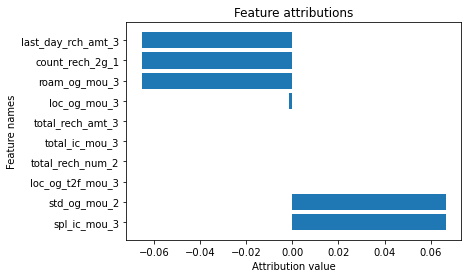

Mobile number: 7000369789, churned?: 1, predicted churn_probability: 97.87%
Label Index [0]
Example Score: 0.9787
Baseline Score: 0.9787
Mobile number: 7000721289, churned?: 0, predicted churn_probability: 0.06%
Label Index [1]
Example Score: 1.0000
Baseline Score: 0.2214
Approximation Error: 0.0108


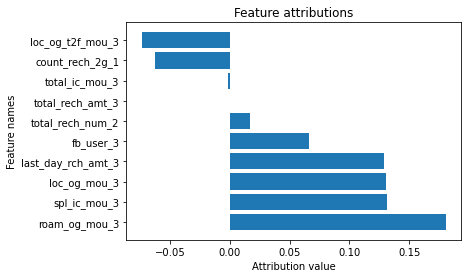

Mobile number: 7001825999, churned?: 0, predicted churn_probability: 0.00%
Label Index [1]
Example Score: 1.0000
Baseline Score: 0.1593
Approximation Error: 0.0108


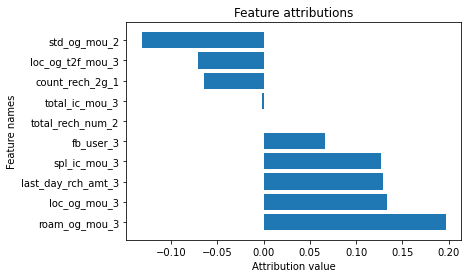

In [528]:
import explainable_ai_sdk
import time

endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/6109981717504720896')


explainable_model = explainable_ai_sdk.load_model_from_vertex(
    project=PROJECT_ID,
    region=REGION,
    endpoint_id=endpoint.name
)

#Generate explainable predictions:
for row in test_data:
    row_copy = row.copy()
    churned = row_copy.pop('is_churned')
    pred = endpoint.predict([row_copy]).predictions[0]
    #print(endpoint.explain([row_copy]))
    m= pred['mobile_number']
    p= pred['churn_probability'][0]
    print(f"Mobile number: {m}, churned?: {churned}, predicted churn_probability: {p:.2%}")
    response = explainable_model.explain([row_copy])
    response[0].visualize_attributions()
    response[0].visualize_top_k_features()


### 5.3 Model Monitoring
_Show in console_

In [19]:
# ToDo - Create Model Monitoring Job Programmatically
# Send predictions to generate alert for feature attribution drift/prediction drift
# Test out 

google-cloud-aiplatform==1.17.0


## 6. Vertex Pipeline
Create a vertex pipeline that orchestrate feature serving, model training, evaluation, and deployment

### 6.1 Create components with Kubeflow SDK

#### 6.1.1 Feature serving component

In [166]:
TRAINING_DATA_SELECTOR_LOC = BUCKET_NAME + '/dataset/query_instance_2.csv'
TRAINING_DATA_TABLE = '{}.aiml_day.t_telecom_high_value_customers_from_feature_store'.format(PROJECT_ID)

@component(base_image='gcr.io/deeplearning-platform-release/tf2-gpu.2-8',
           packages_to_install=[
               'pandas', 
               "google-cloud-bigquery-storage",
               'google-cloud-bigquery', 
               'pyarrow ',
               'fsspec', 
               'gcsfs', 
               'google-cloud-aiplatform==1.17.0'])

def feature_store_serve_op(api_endpoint: str, 
    project_id: str, 
    region: str, 
    featurestore_id: str, 
    bq_feature_source: str,
    bq_training_output: str,
    training_data_selector_loc: str):
    import google.auth
    from google.cloud import bigquery
    from google.cloud import bigquery_storage
    from google.cloud.aiplatform_v1beta1 import (
        FeaturestoreOnlineServingServiceClient, FeaturestoreServiceClient)
    from google.cloud.aiplatform_v1beta1.types import FeatureSelector, IdMatcher
    from google.cloud.aiplatform_v1beta1.types import \
        entity_type as entity_type_pb2
    from google.cloud.aiplatform_v1beta1.types import feature as feature_pb2
    from google.cloud.aiplatform_v1beta1.types import \
        featurestore as featurestore_pb2
    from google.cloud.aiplatform_v1beta1.types import \
        featurestore_monitoring as featurestore_monitoring_pb2
    from google.cloud.aiplatform_v1beta1.types import \
        featurestore_online_service as featurestore_online_service_pb2
    from google.cloud.aiplatform_v1beta1.types import \
        featurestore_service as featurestore_service_pb2
    from google.cloud.aiplatform_v1beta1.types import io as io_pb2
    from datetime import datetime
    import pandas as pd
    
    print("feature store serve task")

    bqclient = bigquery.Client(project_id)
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    query_string = """
    SELECT
        mobile_number
    FROM `{}`
    """.format(bq_feature_source.split('/')[-1])

    user_df = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

    X_train = user_df['mobile_number']
    
    now = datetime.now()

    current_time = now.strftime("%Y-%m-%dT%H:%M:%SZ")
    print("Current Time =", current_time)
    res = pd.DataFrame()
    res['users']  = X_train
    res['timestamp'] = current_time
    res.to_csv(training_data_selector_loc, index=False)
    admin_client = FeaturestoreServiceClient(client_options={"api_endpoint": api_endpoint})
    batch_serving_request = featurestore_service_pb2.BatchReadFeatureValuesRequest(
        # featurestore info
        featurestore=admin_client.featurestore_path(project_id, region, featurestore_id),
        # URL for the label data, i.e., Table 1.
        csv_read_instances=io_pb2.CsvSource(
            gcs_source=io_pb2.GcsSource(uris=[training_data_selector_loc])
        ),
        destination=featurestore_service_pb2.FeatureValueDestination(
            bigquery_destination=io_pb2.BigQueryDestination(
                # Output to BigQuery table created earlier
                output_uri=bq_training_output
            )
        ),
        entity_type_specs=[
            featurestore_service_pb2.BatchReadFeatureValuesRequest.EntityTypeSpec(
                entity_type_id="users",
                feature_selector=FeatureSelector(
                    id_matcher=IdMatcher(
                        ids=['*']
                    )
                ),
            ),
        ],
    )
    batch_serving_lro = admin_client.batch_read_feature_values(batch_serving_request)
    batch_serving_lro.result()

@component(base_image='gcr.io/deeplearning-platform-release/tf2-gpu.2-8',
           packages_to_install=['google-cloud-aiplatform==1.17.0'])
def evaluate_model(
    api_endpoint: str, 
    project_id: str, 
    region: str, 
    model: Input[Artifact],
    metrics: Output[Metrics]):
    model_id = model.metadata['resourceName'].split('/')[-1]
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    from google.cloud import aiplatform
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    name = client.model_path(
        project=project_id, location=region, model=model_id
    )
    print(name)
    response = client.list_model_evaluations(parent=name)
    print("response:", response)
    print(model)
    print(model.metadata)
    print(model.uri)
    print(model.name)
    auRoc = response.__getattr__('model_evaluations')[0].metrics['aucPR']
    metrics.log_metric("aucPR", float(aucPR))


#### 6.1.2 Customized Training Component

In [193]:
from google.cloud.aiplatform import datasets
from google.cloud import aiplatform
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, Input, component, Model, Dataset, Artifact, Condition
from kfp.v2.google.client import AIPlatformClient

CUSTOM_MODEL_DIR = BUCKET_NAME + '/model/sample_model-' + TIMESTAMP
TENSORBOARD_LOG_DIR = BUCKET_NAME + '/mode/tb-logs-' + TIMESTAMP


# @component(base_image='gcr.io/deeplearning-platform-release/tf2-gpu.2-8',
#            packages_to_install=[
#                                 'pandas', 
#                                 "google-cloud-bigquery-storage",
#                                 'google-cloud-bigquery', 
#                                 'pyarrow',
#                                 'fsspec', 
#                                 'gcsfs', 
#                                 'google-cloud-aiplatform==1.17.0',
#                                 'kfp==1.8.11',
#                                 'kfp-pipeline-spec',
#                                 'kfp-server-api',
#                                 'pandas==1.2.4',
#                                 'pandas-profiling==3.0.0',
#                                 'tensorboard==2.5.0',
#                                 'tensorboard-data-server==0.6.1',
#                                 'tensorboard-plugin-wit==1.8.0',
#                                 'tensorflow==2.5.0',
#                                 'tensorflow-datasets==4.3.0',
#                                 'tensorflow-estimator==2.5.0',
#                                 'tensorflow-metadata==1.0.0',
#                                 'google-cloud-logging==2.4.0',
#                                 'explainable-ai-sdk==1.3.0',
#                                 'numpy==1.19.5',
#                                 'sklearn'])


@component(base_image='gcr.io/deeplearning-platform-release/tf2-gpu.2-8',
           packages_to_install=[
                                'pandas', 
                                "google-cloud-bigquery-storage",
                                'google-cloud-bigquery', 
                                'pyarrow',
                                'fsspec', 
                                'gcsfs', 
                                'google-cloud-aiplatform',
                                'kfp',
                                'kfp-pipeline-spec',
                                'kfp-server-api',
       
                                'tensorboard',
                                'tensorboard-data-server'])
def custom_training_op(
    project_id: str,
    dataset: Input[Artifact],
    metrics: Output[Metrics],
    model_dir: str,
    tensorboard_log_dir: str,
):
    from google.cloud.aiplatform import datasets
    from google.cloud import aiplatform
    import logging
    import os
    import tensorflow as tf
    import pandas as pd
    from google.cloud import bigquery
    from google.cloud import bigquery_storage
    from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, component
    import numpy as np
    
    dataset = aiplatform.TabularDataset('projects/' + dataset.metadata['resourceName'].split('projects/')[-1])
    table_id = dataset._gca_resource.metadata.get("inputConfig").get("bigquerySource").get("uri").split('//')[-1]
    
    bqclient = bigquery.Client(project_id)
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    
    # Set up training variables
    LABEL_COLUMN = "is_churned"
    UNUSED_COLUMNS = ['mobile_number','timestamp','entity_type_users']
    NA_VALUES = ["NA", "."]
    

    query_string = """
    SELECT
      * 
    FROM `{}`
    """.format(table_id)

    df = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    
    def preprocess(df):
        """Converts categorical features to numeric. Removes unused columns.

        Args:
          df: Pandas df with raw data

        Returns:
          df with preprocessed data
        """
        df = df.drop(columns=UNUSED_COLUMNS)

        # Drop rows with NaN's
        df = df.dropna()

        # Convert integer valued (numeric) columns to floating point
        numeric_columns = df.select_dtypes(["int32", "float32", "float64","bool"]).columns
        df[numeric_columns] = df[numeric_columns].astype("float32")

        return df


    output_directory = model_dir
    if os.environ.get('AIP_MODEL_DIR') is not None:
        output_directory = os.environ["AIP_MODEL_DIR"]

    logging.info('Creating and training model ...')
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    log_dir = tensorboard_log_dir
    if os.environ.get('AIP_TENSORBOARD_LOG_DIR') is not None:
        log_dir = os.environ["AIP_TENSORBOARD_LOG_DIR"]

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      histogram_freq=1)

    df = df.fillna(0)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(curve='PR')])
    
    df = preprocess(df)
    
    y_train = df.pop('is_churned')
    
    #X_train, y_train = df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']][1000:], df['is_churned'][1000:]
    #model.fit(X_train, y_train, epochs=10, verbose=1, batch_size=10, callbacks=[tensorboard_callback])
    model.fit(df[20000:], y_train[20000:], epochs=10, verbose=1, batch_size=10, callbacks=[tensorboard_callback])


    logging.info(f'Exporting SavedModel to: {output_directory}')
    model.save(output_directory)

    #result = model.evaluate(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']][:1000], df['is_churned'][:1000])
    result = model.evaluate(df[:5000], y_train[:5000])

    
    metrics.log_metric("aucPR", result[1])


#### 6.1.3 Custom component for Model Monitoring

##### 6.1.3.1 Defining an analysis schema for Model Monitoring

In [317]:
%%writefile predict_schema.yaml
type: object
properties:
   mobile_number:
     type: string
   std_og_mou_2:
     type: number
     format: float
   loc_og_mou_3:
     type: number
     format: float
   fb_user_3:
     type: number
     format: float
   total_rech_amt_3:
     type: number
     format: float
   roam_og_mou_3:
     type: number
     format: float
   count_rech_2g_1:
     type: number
     format: float
   total_ic_mou_3:
     type: number
     format: float
   loc_og_t2f_mou_3:
     type: number
     format: float,
   last_day_rch_amt_3:
     type: number
     format: float
   total_rech_num_2:
     type: number
     format: float
   spl_ic_mou_3:
     type: number
     format: float

Overwriting predict_schema.yaml


In [317]:
%%writefile model_analysis_schema.yaml
type: array
properties:
   mobile_number:
     type: string
   std_og_mou_2:
     type: number
     format: float
   loc_og_mou_3:
     type: number
     format: float
   fb_user_3:
     type: number
     format: float
   total_rech_amt_3:
     type: number
     format: float
   roam_og_mou_3:
     type: number
     format: float
   count_rech_2g_1:
     type: number
     format: float
   total_ic_mou_3:
     type: number
     format: float
   loc_og_t2f_mou_3:
     type: number
     format: float,
   last_day_rch_amt_3:
     type: number
     format: float
   total_rech_num_2:
     type: number
     format: float
   spl_ic_mou_3:
     type: number
     format: float

Overwriting predict_schema.yaml


In [318]:
!gsutil cp predict_schema.yaml $BUCKET_NAME/
!echo $BUCKET_NAME

Copying file://predict_schema.yaml [Content-Type=application/octet-stream]...
/ [1 files][  677.0 B/  677.0 B]                                                
Operation completed over 1 objects/677.0 B.                                      
gs://gcp-ml-sandbox-aip-20220913155936


In [339]:
### Customized Component for Model Monitoring

@component(base_image='python:3.9',
           packages_to_install=['google-cloud-aiplatform'])

def model_monitoring_job_op(
    project: str,
    location: str,
    endpoint: Input[Artifact],
    bq_training_data_uri: str = "bq://gcp-ml-sandbox.aiml_day.v_high_value_customers_model_monitoring",
    email: str = 'robv@google.com',

):
    
    from google.cloud import aiplatform 
    from google.cloud.aiplatform import model_monitoring

    def extract_endpoint_uri(uri):
        return uri[uri.find("projects/") :]
    
    aiplatform.init(project=project)

    
    endpoint_uri = extract_endpoint_uri(endpoint.uri)
    
    #Constants for configuring monitoring - look at overriding them:
    
    USER_EMAIL = email
    BUCKET="gs://gcp-ml-sandbox-aip-20220913155936"
    JOB_NAME = "high-value-customer-churn-monitoring_v9999"

    # Sampling rate (optional, default=.8)
    LOG_SAMPLE_RATE = 0.8  # @param {type:"number"}

    # Monitoring Interval in  (optional, default=3600).
    MONITOR_INTERVAL = 1  # @param {type:"number"}

    # URI to training dataset.
    DATASET_BQ_URI = bq_training_data_uri
    # Prediction target column name in training dataset.
    TARGET = "is_churned"

    # # Skew and drift thresholds.

    DEFAULT_THRESHOLD_VALUE = 0.001

    SKEW_THRESHOLDS = {
        "fb_user": DEFAULT_THRESHOLD_VALUE,
        "roam_og_mou_3": DEFAULT_THRESHOLD_VALUE,
    }
    DRIFT_THRESHOLDS = {
        "fb_user": DEFAULT_THRESHOLD_VALUE,
        "roam_og_mou_3": DEFAULT_THRESHOLD_VALUE,
    }
    ATTRIB_SKEW_THRESHOLDS = {
        "fb_user": DEFAULT_THRESHOLD_VALUE,
        "roam_og_mou_3": DEFAULT_THRESHOLD_VALUE,
    }
    ATTRIB_DRIFT_THRESHOLDS = {
        "country": DEFAULT_THRESHOLD_VALUE,
        "roam_og_mou_3": DEFAULT_THRESHOLD_VALUE,
    }


    skew_config = model_monitoring.SkewDetectionConfig(
        data_source=DATASET_BQ_URI,
        skew_thresholds=SKEW_THRESHOLDS,
        attribute_skew_thresholds=ATTRIB_SKEW_THRESHOLDS,
        target_field=TARGET,
    )

    drift_config = model_monitoring.DriftDetectionConfig(
        drift_thresholds=DRIFT_THRESHOLDS,
        attribute_drift_thresholds=ATTRIB_DRIFT_THRESHOLDS,
    )

    explanation_config = model_monitoring.ExplanationConfig()
    objective_config = model_monitoring.ObjectiveConfig(
        skew_config, drift_config, explanation_config
    )

    # Create sampling configuration
    random_sampling = model_monitoring.RandomSampleConfig(sample_rate=LOG_SAMPLE_RATE)

    # Create schedule configuration
    schedule_config = model_monitoring.ScheduleConfig(monitor_interval=MONITOR_INTERVAL)

    # Create alerting configuration.
    emails = [USER_EMAIL]
    alerting_config = model_monitoring.EmailAlertConfig(
        user_emails=emails, enable_logging=True
    )

    # Create the monitoring job.
    job = aiplatform.ModelDeploymentMonitoringJob.create(
        display_name=JOB_NAME,
        logging_sampling_strategy=random_sampling,
        schedule_config=schedule_config,
        alert_config=alerting_config,
        objective_configs=objective_config,
        project=project,
        location=location,
        endpoint=endpoint_uri,
        enable_monitoring_pipeline_logs=True,
        analysis_instance_schema_uri=f"{BUCKET}/predict_schema.yaml",
        #deployed_model_ids=['9005180551392395264']
    )

In [ ]:
#Customized component for creating model evaluation data

@component(base_image='python:3.9',
           packages_to_install=['google-cloud-aiplatform',
                                'google-cloud-bigquery-storage',
               'google-cloud-bigquery', 
               'pyarrow '])

def export_eval_data_op(
    project: str,
    location: str,
    endpoint: Input[Artifact],
    bq_training_data_uri: str = "bq://gcp-ml-sandbox.aiml_day.v_high_value_customers_model_monitoring",
    email: str = 'robv@google.com',

):
    
    from google.cloud.bigquery import Client, QueryJobConfig
from google.cloud import aiplatform
import time

endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/6109981717504720896')
client = Client()

query = """SELECT CAST(mobile_number as STRING) as mobile_number,
        ifnull(std_og_mou_7,0) as std_og_mou_2,
        ifnull(loc_og_mou_8,0) as loc_og_mou_3,
        CAST(ifnull(fb_user_8,0) as INT) as fb_user_3,
        ifnull(total_rech_amt_8,0) as total_rech_amt_3,
        (ifnull(roam_og_mou_8,0) + 0) as roam_og_mou_3,
        ifnull(count_rech_2g_6,0) as count_rech_2g_1,
        ifnull(total_ic_mou_8,0) as total_ic_mou_3,
        ifnull(loc_og_t2f_mou_8,0) as loc_og_t2f_mou_3,
        ifnull(last_day_rch_amt_8,0) as last_day_rch_amt_3,
        ifnull(total_rech_num_7,0) as total_rech_num_2,
        ifnull(spl_ic_mou_8,0) as spl_ic_mou_3
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_eval`"""
job = client.query(query)
df = job.to_dataframe()

test_data = df.to_json(orient='records')

i = 25000
while True:
    for row in test_data:
        if i>0:
            row['roam_og_mou_3']+= 1000
            i-=1
        output = endpoint.predict([row])
        m = output.predictions[0]['mobile_number']
        p = output.predictions[0]['churn_probability']
        print(f"Instance: {row}")
        print(f'Mobile Number: {m}, churn probability: {p[0]:.2%}\n')
        time.sleep(.25)

In [532]:
TIMESTAMP
!gcloud beta ai model-monitoring-jobs list --region $REGION

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
---
analysisInstanceSchemaUri: gs://cloud-ai-platform-ee649820-bb8b-46b3-8516-9f4f443365db/instance_schemas/job-3509226325099413504/analysis
bigqueryTables:
- bigqueryTablePath: bq://gcp-ml-sandbox.model_deployment_monitoring_6109981717504720896.serving_predict
  logSource: SERVING
  logType: PREDICT
createTime: '2022-10-19T14:39:51.931024Z'
displayName: high-value-customer-churn-monitoring_v9999
enableMonitoringPipelineLogs: true
endpoint: projects/357746845324/locations/us-central1/endpoints/6109981717504720896
latestMonitoringPipelineMetadata:
  runTime: '2022-10-24T21:00:00Z'
  status: {}
logTtl: 0s
loggingSamplingStrategy:
  randomSampleConfig:
    sampleRate: 0.8
modelDeploymentMonitoringObjectiveConfigs:
- deployedModelId: '1634758286223867904'
  objectiveConfig:
    explanationConfig:
      enableFeatureAttributes: true
    predictionDriftDetectionConfig:
      attributionScoreDriftThresholds:
        country:
    

In [536]:
!gcloud beta ai model-monitoring-jobs update 3509226325099413504 --project=gcp-ml-sandbox --region=us-central1 --anomaly-cloud-logging

ERROR: (gcloud.beta.ai.model-monitoring-jobs.update) unrecognized arguments: --anomaly-cloud-logging 

To search the help text of gcloud commands, run:
  gcloud help -- SEARCH_TERMS


In [ ]:
!gcloud beta ai model-monitoring-jobs delete  projects/357746845324/locations/us-central1/modelDeploymentMonitoringJobs/53245774720401408 --region $REGION --quiet

---
### 6.2 Build Pipeline With KFP

In [508]:
FEATURE_STORE = FEATURESTORE_ID_TO_CREATE

BQ_FEATURE_SOURCE = "{}.aiml_day.v_high_value_customers_w_label_train".format(PROJECT_ID)
BQ_TRAINING_OUTPUT = 'bq://{}.aiml_day.t_churn_prediction_training_data_{}'.format(PROJECT_ID, TIMESTAMP)
BQ_FEATURE_TABLE = BQ_FEATURE_SOURCE.split('/')[-1]
MODEL_DISPLAY_NAME = 'pipelines-custom-churn-prediction-model'

from google_cloud_pipeline_components.types import artifact_types

@kfp.dsl.pipeline(name="train" + str(uuid.uuid4()))
def pipeline(featurestore_id: str = FEATURE_STORE, 
    bq_feature_source: str = BQ_FEATURE_SOURCE,
    bq_training_output: str = BQ_TRAINING_OUTPUT,
    bq_feature_source_table: str = BQ_FEATURE_TABLE,
    project: str = PROJECT_ID,
    model_display_name: str = MODEL_DISPLAY_NAME,
    api_endpoint: str = API_ENDPOINT, 
    region: str = REGION,
    serving_container_image_uri: str = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-3:latest",
    training_data_selector_loc: str = TRAINING_DATA_SELECTOR_LOC
):
#     feature_store_serve_job = feature_store_serve_op(
#         api_endpoint=api_endpoint, 
#         project_id=project, 
#         region=region, 
#         featurestore_id=featurestore_id, 
#         bq_feature_source=bq_feature_source,
#         bq_training_output=bq_training_output,
#         training_data_selector_loc=training_data_selector_loc)
    
#     dataset_create_job = gcc_aip.TabularDatasetCreateOp(
#         project=project, display_name='dataset_creation_op',
#         bq_source=bq_training_output
#     )
    
#     dataset_create_job.after(feature_store_serve_job)

#     custom_training_job = custom_training_op(
#         project_id=project,
#         dataset=dataset_create_job.outputs["dataset"],
#         model_dir=WORKING_DIR,
#         tensorboard_log_dir=TENSORBOARD_LOG_DIR,
#     )
    
#     custom_training_job.after(dataset_create_job)
    
#     endpoint_create_job = gcc_aip.EndpointCreateOp(
#         project=project,
#         display_name="pipelines-created-endpoint",
#     )
    
#     automl_training_job = gcc_aip.AutoMLTabularTrainingJobRunOp(
#         project=project,
#         display_name='automl_training_op',
#         optimization_prediction_type="classification",
#         budget_milli_node_hours=1000,
#         column_transformations=[
#            {"numeric": {"column_name":"std_og_mou_2"}},
#             {"numeric": {"column_name":"loc_og_mou_3"}},
#             {"categorical": {"column_name":"fb_user_3"}},
#             {"numeric": {"column_name":"total_rech_amt_3"}},
#             {"numeric": {"column_name":"roam_og_mou_3"}},
#             {"numeric": {"column_name":"count_rech_2g_1"}},
#             {"numeric": {"column_name":"total_ic_mou_3"}},
#             {"numeric": {"column_name":"loc_og_t2f_mou_3"}},
#             {"numeric": {"column_name":"last_day_rch_amt_3"}},
#             {"numeric": {"column_name":"total_rech_num_2"}},
#             {"numeric": {"column_name":"spl_ic_mou_3"}},
#             {"categorical": {"column_name": "is_churned"}},
#         ],
#         dataset=dataset_create_job.outputs["dataset"],
#         target_column="is_churned",
#     )
#     automl_training_job.after(dataset_create_job)

#     evaluate_model(
#         api_endpoint=api_endpoint, 
#         project_id=project, 
#         region=region, 
#         model=automl_training_job.outputs["model"])
    
#     automl_model_deploy_job = gcc_aip.ModelDeployOp(
#         #traffic_percentage=100,
#         endpoint=endpoint_create_job.outputs["endpoint"],
#         model=automl_training_job.outputs["model"],
#         #project=project,
#         dedicated_resources_machine_type="n1-standard-4",
#         dedicated_resources_min_replica_count=1
#     )
#     custom_model_upload_job = gcc_aip.ModelUploadOp(
#         project=project,
#         display_name=model_display_name,
#         artifact_uri=WORKING_DIR,
#         serving_container_image_uri=serving_container_image_uri,
#         #serving_container_environment_variables={"NOT_USED": "NO_VALUE"},
#     )
#     custom_model_upload_job.after(custom_training_job)
    
    
    endpoint_uri="https://us-central1-aiplatform.googleapis.com/v1/projects/357746845324/locations/us-central1/endpoints/6109981717504720896"
    endpoint = kfp.v2.dsl.importer(
        artifact_uri=endpoint_uri,
        artifact_class=artifact_types.VertexEndpoint,
      )
    endpoint.set_display_name('Import endpoint')
    
    model_monitoring_job = model_monitoring_job_op(
        project=project,
        location=region,
        endpoint= endpoint.output,
    ).set_display_name('Create model monitoring job')

#     custom_model_deploy_job = gcc_aip.ModelDeployOp(
#         traffic_split={"0":100},
#         #endpoint=endpoint,
#         endpoint=endpoint_create_job.outputs["endpoint"],
#         model=custom_model_upload_job.outputs["model"],
#         deployed_model_display_name=model_display_name,
#         dedicated_resources_machine_type="n1-standard-4",
#         dedicated_resources_min_replica_count=1

#    )

---
### 6.3 Compile and upload pipeline to Vertex AI

Now, you're ready to compile the pipeline:

In [509]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="telecom-sample-pipeline.json"
)

The pipeline compilation generates the `train_upload_deploy.json` job spec file.

Next, instantiate an API client object:

In [510]:
from kfp.v2.google.client import AIPlatformClient
api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,


In [153]:
PIPELINE_ROOT

'gs://gcp-ml-sandbox-aip-20220913155936/pipeline_root/robv'

In [154]:
print (FEATURE_STORE)

telco_churn_prediction_20220913155936


from datetime import datetime
Then, you run the defined pipeline like this: 

In [511]:
from datetime import datetime
TABLE_TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BQ_FEATURE_STORE_OUTPUT = 'bq://{}.aiml_day.t_high_value_customers_pipelines_training_data_{}'.format(PROJECT_ID, TABLE_TIMESTAMP)


response = api_client.create_run_from_job_spec( "telecom-sample-pipeline.json", pipeline_root=PIPELINE_ROOT,
    parameter_values={
        "project": PROJECT_ID,
        'bq_feature_source': BQ_FEATURE_SOURCE,
        "bq_training_output": BQ_FEATURE_STORE_OUTPUT,
        'featurestore_id': FEATURE_STORE,
        'training_data_selector_loc' : TRAINING_DATA_SELECTOR_LOC
    },
    enable_caching=True)
#response = api_client.create_schedule_from_job_spec(job_spec_path = "train_upload_deploy.json",
#                                  schedule="2 * * * *")

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:
- Delete Cloud Storage objects that were created.  Uncomment and run the command in the cell below **only if you are not using the `PIPELINE_ROOT` path for any other purpose**.
- Delete your deployed model: first, undeploy it from its *endpoint*, then delete the model and endpoint.


In [ ]:
# Warning: this command will delete ALL Cloud Storage objects under the PIPELINE_ROOT path.
# ! gsutil -m rm -r $PIPELINE_ROOT

In [ ]:
endpoints = aiplatform.Endpoint.list()

In [ ]:
# Warning: this command will delete ALL endpoints in the projects
for endpoint in endpoints:
    try:
        endpoint.delete(force=True)
    except:
        print("delete fail~!!!! ")
        print(endpoint)

In [320]:
# Clean up Feature Store
from google.cloud import aiplatform as aip

mfs = aip.Featurestore(
    featurestore_name='telecom_churn_prediction_20220524151304'
)
mfs.delete(force=True)

Deleting Featurestore : projects/357746845324/locations/us-central1/featurestores/telecom_churn_prediction_20220524151304


INFO:google.cloud.aiplatform.featurestore.featurestore:Deleting Featurestore : projects/357746845324/locations/us-central1/featurestores/telecom_churn_prediction_20220524151304


Delete Featurestore  backing LRO: projects/357746845324/locations/us-central1/operations/5203032302745026560


INFO:google.cloud.aiplatform.featurestore.featurestore:Delete Featurestore  backing LRO: projects/357746845324/locations/us-central1/operations/5203032302745026560


Featurestore deleted. . Resource name: projects/357746845324/locations/us-central1/featurestores/telecom_churn_prediction_20220524151304


INFO:google.cloud.aiplatform.featurestore.featurestore:Featurestore deleted. . Resource name: projects/357746845324/locations/us-central1/featurestores/telecom_churn_prediction_20220524151304


# Appendix and Graveyard

In [319]:
# Run the following in the terminal, after copying the model artifacts to /tmp/model/1
#docker run -d -p 8501:8501 --mount type=bind,source=/tmp/model,target=/models/model -e MODEL_NAME=model -t tensorflow/serving

In [346]:
mdm_job = aiplatform.ModelDeploymentMonitoringJob('projects/357746845324/locations/us-central1/modelDeploymentMonitoringJobs/53245774720401408')
mdm_job
print(mdm_job.state, mdm_job.display_name)
mdm_job.list(filter='display_name="high-value-customer-churn-monitoring_v9999"')

JobState.JOB_STATE_PENDING high-value-customer-churn-monitoring_v9999


 resource name: projects/357746845324/locations/us-central1/modelDeploymentMonitoringJobs/53245774720401408]

In [341]:
mdm_job = aiplatform.ModelDeploymentMonitoringJob('projects/357746845324/locations/us-central1/modelDeploymentMonitoringJobs/5366367435110744064')
mdm_job.delete()

## TESTING Imported BQML model
What does the model signature in Vertex look like?

In [248]:
import explainable_ai_sdk

endpoint = aiplatform.Endpoint('3681274880956825600')

explainable_model = explainable_ai_sdk.load_model_from_vertex(
    project=PROJECT_ID,
    region=REGION,
    endpoint_id=endpoint.name
)

#Generate explainable predictions:
for row in test_data:
    row_copy = row.copy()
    churned = row_copy.pop('is_churned')
    mobile_number =row_copy.pop('mobile_number')
    row_copy['fb_user_3'] = bool(row_copy['fb_user_3'])
    row_copy['total_rech_amt_3'] = str(row_copy['total_rech_amt_3'])
    row_copy['count_rech_2g_1'] = str(row_copy['count_rech_2g_1'])
    row_copy['last_day_rch_amt_3']= str(row_copy['last_day_rch_amt_3'])
    row_copy['total_rech_num_2']=str(row_copy['total_rech_num_2'])

    pred = endpoint.predict([row_copy]).predictions[0]
    print(pred)
    # # m= pred['mobile_number']
    # # p= pred['churn_probability'][0]
    # # print(f"Mobile number: {m}, churned?: {churned}, predicted churn_probability: {p:.2%}")
    # response = explainable_model.explain([row_copy])
    # response[0].visualize_attributions()
    # response[0].visualize_top_k_features()


{'predicted_is_churned': 'false', 'is_churned_probs': [0.092753566801548, 0.9072464108467102], 'is_churned_values': ['true', 'false']}
{'predicted_is_churned': 'false', 'is_churned_probs': [0.1004934906959534, 0.8995065093040466], 'is_churned_values': ['true', 'false']}
{'is_churned_probs': [0.09204544872045517, 0.9079545140266418], 'is_churned_values': ['true', 'false'], 'predicted_is_churned': 'false'}
{'is_churned_values': ['true', 'false'], 'is_churned_probs': [0.1128044798970222, 0.8871955871582031], 'predicted_is_churned': 'false'}
{'is_churned_probs': [0.7991770505905151, 0.2008229792118073], 'is_churned_values': ['true', 'false'], 'predicted_is_churned': 'true'}
{'is_churned_probs': [0.4426820874214172, 0.5573179125785828], 'predicted_is_churned': 'false', 'is_churned_values': ['true', 'false']}
{'is_churned_probs': [0.7936922311782837, 0.2063077092170715], 'predicted_is_churned': 'true', 'is_churned_values': ['true', 'false']}
{'is_churned_values': ['true', 'false'], 'predicte

In [243]:
# Get boosted tree classifier model and associated serving container
bq_model = aiplatform.Model('projects/357746845324/locations/us-central1/models/high_value_customers_churn_boosted_tree_v2')
#dir(bq_model)
print(bq_model.supported_deployment_resources_types)

[<DeploymentResourcesType.DEDICATED_RESOURCES: 1>]


In [ ]:
#model evaluation pipeline - must be a table (format not right)

## WIP - Thoughts on structuring model contract for prediction/XAI/monitoring/evaluation
* Online Prediction - one format documented, but not well supported by model monitoring
```
{"instance": [
         {"key":instance_key, "features":[value1, value2, value3]}
         ]
    }
```
* AutoML Online Prediction - how are values typed?
  * Even when specifying the column is numeric, the model expects the value to be passed in as a string.  why?  BQ to JSON mapping - INT/INT64 mapped as String vs number
  * https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#format-for-prediction
  
* BQML Classification model that is imported into Vertex
  * Payload format:  key/value pairs - see log reg example here
  * Not as picky as AutoML payload - works the same
  * Need to figure out a way to standardize the output signature of these models

* Custom Models
  * Prebuilt containers:
      * Tensorflow - format
      * XGBoost - format
      * scikit-learn - format
  * Custom containers (do what you want)
  
* Model Monitoring: typically would expect key/value pairs for monitoring feature inputs/outputs e.g. 
 ```{"instance":[{"feature1":value1, "feature2": value2}]}```
  * anonymous features can be specified using an analysis/predict schema (why is there a seperate option for an analysis schema - where would they be different?)
  
* Batch Prediction:
  * If data is coming from BQ, BQ passes in features as a flat list of feature values. see: https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#bigquery
  * JSONL more flexible (can match above)
  
* Model eval
  * For classification, expects the output to be formatted similar to the Tensorflow Classification API:
 ```{'scores [.2,.8],classes['will_churn','will_not_churn']}```
 
* XAI
  * BAG_OF_FEATURES can be used to give feature names where input tensor is an array
  * Why does it have this separate way of defining metadata - can't this also use a schema object?

In [529]:
### Local testing (running Docker in another container)

In [288]:
import json, requests

url = "http://localhost:8501/v1/models/model:predict"

instances = [{
"mobile_number": "7000721289",
  "std_og_mou_2": 94.89,
  "loc_og_mou_3": 203.21,
  "fb_user_3": 0,
  "total_rech_amt_3": 410,
  "roam_og_mou_3": 0.0,
  "count_rech_2g_1": 0,
  "total_ic_mou_3": 206.94,
  "loc_og_t2f_mou_3": 14.88,
  "last_day_rch_amt_3": 110,
  "total_rech_num_2": 4,
  "spl_ic_mou_3": 0.0
},{
"mobile_number": "7000721289",
  "std_og_mou_2": 94.89,
  "loc_og_mou_3": 203.21,
  "fb_user_3": 0,
  "total_rech_amt_3": 410,
  "roam_og_mou_3": 0.0,
  "count_rech_2g_1": 0,
  "total_ic_mou_3": 206.94,
  "loc_og_t2f_mou_3": 14.88,
  "last_day_rch_amt_3": 110,
  "total_rech_num_2": 4,
  "spl_ic_mou_3": 0.0
}]



def make_prediction(instances):
    data = json.dumps({"signature_name": "serving_default", "instances": instances})
    headers = {"content-type": "application/json"}
    json_response = requests.post(url, data=data, headers=headers)
    print(json_response.text)
    #predictions = json.loads(json_response.text)["predictions"]
    #return predictions[0]


make_prediction(instances)

{
    "predictions": [
        {
            "churn_probability": [5.62442e-05],
            "mobile_number": "7000721289"
        },
        {
            "churn_probability": [0.0046278839],
            "mobile_number": "7000721289"
        }
    ]
}


#@bigquery
SELECT mobile_number as key, ARRAY<FLOAT64>[
        ifnull(std_og_mou_7,0),
        ifnull(loc_og_mou_8,0),
        CAST(ifnull(fb_user_8,0) as INT),
        ifnull(total_rech_amt_8,0),
        ifnull(roam_og_mou_8,0),
        ifnull(count_rech_2g_6,0),
        ifnull(total_ic_mou_8,0),
        ifnull(loc_og_t2f_mou_8,0),
        ifnull(last_day_rch_amt_8,0),
        ifnull(total_rech_num_7,0),
        ifnull(spl_ic_mou_8,0)] as features
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_predict`

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """SELECT mobile_number as key, ARRAY<FLOAT64>[
        ifnull(std_og_mou_7,0),
        ifnull(loc_og_mou_8,0),
        CAST(ifnull(fb_user_8,0) as INT),
        ifnull(total_rech_amt_8,0),
        ifnull(roam_og_mou_8,0),
        ifnull(count_rech_2g_6,0),
        ifnull(total_ic_mou_8,0),
        ifnull(loc_og_t2f_mou_8,0),
        ifnull(last_day_rch_amt_8,0),
        ifnull(total_rech_num_7,0),
        ifnull(spl_ic_mou_8,0)] as features
         FROM `gcp-ml-sandbox.aiml_day.v_high_value_customers_w_label_predict`"""
job = client.query(query)
df = job.to_dataframe()

## GRAVEYARD
from original APAC notebook)

### 3.1.1 Using managed tensorboard to track experiments

In [ ]:
! pip install --user -U pip
! pip install --user google-cloud-aiplatform[tensorboard]

In [76]:
! gcloud beta ai tensorboards create --display-name telco_churn_tb \
  --project $PROJECT_ID \
  --region $REGION

E0302 21:52:46.976592019    5459 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1646257966.976445653","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1646257966.976428588","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [101300823765549056]...done.                             
Created Vertex AI Tensorboard: projects/357746845324/locations/us-central1/tensorboards/2199603797691465728.


Copy the output of created tensorboard ID, and paste here:

In [31]:
tensorboard_id = 'projects/357746845324/locations/us-central1/tensorboards/2199603797691465728'

In [32]:
! tb-gcp-uploader --tensorboard_resource_name $tensorboard_id \
  --logdir=$TENSORBOARD_LOG_DIR\train \
  --experiment_name=telco-churn-v2 --one_shot=True

2022-05-24 15:33:02.511940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-24 15:33:02.511992: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 15:33:02.512043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vm-fd5bd6d3-a885-42c2-ba29-1c4b3a5e3380): /proc/driver/nvidia/version does not exist
View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+357746845324+locations+us-central1+tensorboards+2199603797691465728+experiments+telco-churn-v2
W0524 15:33:14.583338 139843275261760 uploader.

### 3.1.2 Vizier (auto hyper parameter tuning)

#### import package

In [33]:
from google.cloud import aiplatform_v1beta1
import datetime
import json

#### Create study configuration

In [34]:
# Parameter Configuration
STUDY_DISPLAY_NAME = "{}_study_{}".format(
    PROJECT_ID.replace("-", ""), datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
)  # @param {type: 'string'}

param_lr = {"parameter_id": "lr", "double_value_spec": {"min_value": 0.01, "max_value": 0.1}}

param_hs = {
    "parameter_id": "hiddenSize",
    "integer_value_spec": {"min_value": 3, "max_value": 10},
}

# Objective Metrics
metric_auc = {"metric_id": "auc", "goal": "MAXIMIZE"}

# Put it all together in a study configuration
study = {
    "display_name": STUDY_DISPLAY_NAME,
    "study_spec": {
        "algorithm": "RANDOM_SEARCH",
        "parameters": [
            param_lr,
            param_hs,
        ],
        "metrics": [metric_auc],
    },
}

print(json.dumps(study, indent=2, sort_keys=True))

{
  "display_name": "gcpmlsandbox_study_20220524_153332",
  "study_spec": {
    "algorithm": "RANDOM_SEARCH",
    "metrics": [
      {
        "goal": "MAXIMIZE",
        "metric_id": "auc"
      }
    ],
    "parameters": [
      {
        "double_value_spec": {
          "max_value": 0.1,
          "min_value": 0.01
        },
        "parameter_id": "lr"
      },
      {
        "integer_value_spec": {
          "max_value": 10,
          "min_value": 3
        },
        "parameter_id": "hiddenSize"
      }
    ]
  }
}


#### create study

In [35]:
ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT = "projects/{}/locations/{}".format(PROJECT_ID, REGION)
vizier_client = aiplatform_v1beta1.VizierServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)
study = vizier_client.create_study(parent=PARENT, study=study)
STUDY_ID = study.name
print("STUDY_ID: {}".format(STUDY_ID))

STUDY_ID: projects/357746845324/locations/us-central1/studies/183669800704


#### Set evaluation metrics

In [36]:
def MetricAUCEvaluation(hs, lr, df):
    model = getModel(hs, lr, df)
    result = model.evaluate(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']][:1000], df['is_churn'][:1000])
    return result[1]


def CreateMetrics(trial_id, hs, lr, df):
    print(("=========== Start Trial: [{}] =============").format(trial_id))

    # Evaluate both objective metrics for this trial
    auc = MetricAUCEvaluation(hs, lr, df)
    print(
        "[hidden size = {}, lr = {}] => auc = {}".format(
            hs, lr, auc
        )
    )
    metric1 = {"metric_id": "auc", "value": auc}

    # Return the results for this trial
    return [metric1]

#### Set configuration parameters for running trials


In [37]:
client_id = "telco-churn-hp-tuning-client"  # @param {type: 'string'}
suggestion_count_per_request = 5  # @param {type: 'integer'}
max_trial_id_to_stop = 4  # @param {type: 'integer'}

print("client_id: {}".format(client_id))
print("suggestion_count_per_request: {}".format(suggestion_count_per_request))
print("max_trial_id_to_stop: {}".format(max_trial_id_to_stop))

client_id: telco-churn-hp-tuning-client
suggestion_count_per_request: 5
max_trial_id_to_stop: 4


In [38]:
df

,timestamp,entity_type_users,mou_m1,mou_m2,mou_m3,arpu_m1,arpu_m2,arpu_m3,is_churn
0,2022-05-24 15:27:51+00:00,7000001489,1072.14,33.03,0.00,495.051,43.840,0.000,False
1,2022-05-24 15:27:51+00:00,7000001489,1072.14,33.03,0.00,495.051,43.840,0.000,False
2,2022-05-24 15:27:51+00:00,7000001507,91.46,0.00,0.00,255.620,210.948,530.672,False
3,2022-05-24 15:27:51+00:00,7000001507,91.46,0.00,0.00,255.620,210.948,530.672,False
4,2022-05-24 15:27:51+00:00,7000001992,96.26,52.93,0.00,903.885,487.638,0.610,False
...,...,...,...,...,...,...,...,...,...
199993,2022-05-24 15:27:51+00:00,7000348752,0.00,0.00,1.56,51.370,80.181,13.400,True
199994,2022-05-24 15:27:51+00:00,7000712419,0.00,0.00,1.56,213.815,0.000,111.335,True
199995,2022-05-24 15:27:51+00:00,7000712419,0.00,0.00,1.56,213.815,0.000,111.335,True
199996,2022-05-24 15:27:51+00:00,7001098628,0.00,0.00,1.56,130.449,130.443,769.132,True


#### Run vertex Vizier trials

In [39]:
trial_id = 0
while int(trial_id) < max_trial_id_to_stop:
    suggest_response = vizier_client.suggest_trials(
        {
            "parent": STUDY_ID,
            "suggestion_count": suggestion_count_per_request,
            "client_id": client_id,
        }
    )

    for suggested_trial in suggest_response.result().trials:
        trial_id = suggested_trial.name.split("/")[-1]
        trial = vizier_client.get_trial({"name": suggested_trial.name})

        if trial.state in ["COMPLETED", "INFEASIBLE"]:
            continue
        for param in trial.parameters:
            if param.parameter_id == "lr":
                lr = param.value
            elif param.parameter_id == "hiddenSize":
                hs = param.value
        print("Trial : hidden size is {}, lr is {}.".format(hs, lr))

        vizier_client.add_trial_measurement(
            {
                "trial_name": suggested_trial.name,
                "measurement": {
                    "metrics": CreateMetrics(suggested_trial.name, hs, lr, df)
                },
            }
        )

        response = vizier_client.complete_trial(
            {"name": suggested_trial.name, "trial_infeasible": False}
        )

Trial : hidden size is 8.0, lr is 0.04671685219075789.
=========== Start Trial: [projects/357746845324/locations/us-central1/studies/183669800704/trials/1] =============
Epoch 1/2
19900/19900 [==============================] - 33s 2ms/step - loss: 0.3746 - auc_1: 0.5401
Epoch 2/2
32/32 [==============================] - 0s 1ms/step - loss: 0.1009 - auc_1: 0.0000e+00
[hidden size = 8.0, lr = 0.04671685219075789] => auc = 0.0
Trial : hidden size is 3.0, lr is 0.09077749306147469.
=========== Start Trial: [projects/357746845324/locations/us-central1/studies/183669800704/trials/2] =============
Epoch 1/2
19900/19900 [==============================] - 33s 2ms/step - loss: 0.3336 - auc_2: 0.5008
Epoch 2/2
32/32 [==============================] - 1s 2ms/step - loss: 0.1172 - auc_2: 0.0000e+00
[hidden size = 3.0, lr = 0.09077749306147469] => auc = 0.0
Trial : hidden size is 7.0, lr is 0.05487920056017323.
=========== Start Trial: [projects/357746845324/locations/us-central1/studies/18366980070

---
### 3.2 Deploy trained model to Vertex AI endpoint 
Upload model

In [41]:
! gcloud ai models upload \
  --region=us-central1  \
  --display-name=churn-model-explain-{TIMESTAMP} \
  --container-image-uri=us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-3:latest  \
  --artifact-uri={CUSTOM_MODEL_DIR} \
 # --explanation-method=sampled-shapley \
 # --explanation-path-count=10 \
 # --explanation-metadata-file=./churn_prediction_model/explanation_metadata.json

E0524 15:41:51.068420669    1324 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1653406911.068070852","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1653406911.068058951","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6284080106633691136]...done.                            


To take a quick anonymous survey, run:
  $ gcloud survey



Deploy to endpoint

In [410]:
! gcloud beta ai models list \
  --region={REGION} \
  --filter=display_name=churn-model-explain-{TIMESTAMP}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ERROR: gcloud crashed (InvalidDataFromServerError): Error decoding response "{
  "models": [
    {
      "name": "projects/357746845324/locations/us-central1/models/7763392118982180864",
      "displayName": "high_value_customers_churn_automl",
      "predictSchemata": {
        "instanceSchemaUri": "https://storage.googleapis.com/caip-tenant-96a011b9-4766-4ccf-abb6-5b14936cc06c/schema/predict/instance.yaml?GoogleAccessId=service-357746845324@gcp-sa-aiplatform.iam.gserviceaccount.com&Expires=1663961067&Signature=eu4UkF5cffixi%252BwFEVxWzFz1HqgbAiYZk%252BCnXe5Mwx%252Fte1H2948b7fg5i60hDcdb66YEHY4kRDYI0M58irSmunCmc9hXrXkgcFoQXIfMw5nTfL9EUAArzV4zNx4TlI34eKJ5vZk9tE4%252BmgrdwaEjgRRT7rZSMAzofhAUEHJNaFsane9%252B2RAawOUwBEDVf%252Fbvbgp5xdpwhi6sEguI3CQsOrudSEWOFLwWYlIGMrHmufbIHqwIWXHN0Q79SK9lRdCzNjSxtlPOgaqvpR94o8GxmE1zH%252BTgc%252BS5ONKLjQHuuDpdMzsKB5we9pxwltnxYlEaeh%252BjjjxikAxdclVU6aLy3g%253D%253D",
        "predictionSchemaUr

In [43]:
MODEL_ID = '139299327146196992'
model = aiplatform.Model(MODEL_ID)
model.update(labels ={'release':'test'})

resource name: projects/357746845324/locations/us-central1/models/139299327146196992

---
### 3.3 Make explainable prediction

In [71]:
#RJV - for repeatability
TIMESTAMP="20220302175744"

In [72]:
! gcloud ai endpoints list \
  --region={REGION} \
  --filter=display_name=churn-model-explain-{TIMESTAMP}_endpoint

E0531 17:31:21.244233195    1599 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1654018281.244014776","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1654018281.244002249","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
2816183530269179904  churn-model-explain-20220302175744_endpoint


In [79]:
# Copy and paste the endpoint ID from the output of last block in the ENDPOINT_ID field
ENDPOINT_ID = '2816183530269179904'
vertex_model = explainable_ai_sdk.load_model_from_vertex(
    project=PROJECT_ID,
    region=REGION,
    endpoint_id=ENDPOINT_ID
)


response = vertex_model.explain(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']].values.tolist()[:10])
response[0].visualize_attributions()
#response[0].feature_importance()
#print('--------\n')
#print(response[0].as_tensors())
#print(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']].values.tolist()[0])


Label Index [0]
Example Score: 0.0408
Baseline Score: 0.5907
Approximation Error: 0.0029


---
### 3.4 Explain the model: What-if tool
#### 3.4.1 Install the What-if tool and jupyter widget
<font color='red'>Note that if it's the first time you use What-if tool in notebook, you may need to restart the browser tab</font>

In [ ]:
# !pip install --user witwidget witwidget-gpu
# !sudo /opt/conda/bin/jupyter labextension install wit-widget
# !sudo /opt/conda/bin/jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [81]:
df.head()

#Get reference to Endpoint in case we have to restart our kernel
endpoint = aiplatform.Endpoint('projects/357746845324/locations/us-central1/endpoints/756771863165665280')


endpoint.predict(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3']].values.tolist()[:100])

Prediction(predictions=[[0.276678532], [0.276678532], [1.95433302e-07], [1.95433302e-07], [0.000743865967], [0.000743865967], [0.0353280902], [0.0353280902], [0.00472265482], [0.00472265482], [0.546140969], [0.546140969], [0.326845], [0.326845], [0.214801043], [0.214801043], [1.97822847e-05], [1.97822847e-05], [0.196256697], [0.196256697], [0.00422120094], [0.00422120094], [0.000160634518], [0.000160634518], [0.000192582607], [0.000192582607], [0.632141709], [0.632141709], [1.83592783e-05], [1.83592783e-05], [0.000169783831], [0.000169783831], [0.399408311], [0.399408311], [0.000586956739], [0.000586956739], [0.632141709], [0.632141709], [0.134839535], [0.134839535], [0.504288316], [0.504288316], [0.244741112], [0.244741112], [0.632141709], [0.632141709], [0.104944229], [0.104944229], [0.0273616016], [0.0273616016], [0.632141709], [0.632141709], [0.0163757801], [0.0163757801], [0.227279693], [0.227279693], [0.367273331], [0.367273331], [0.20886758], [0.20886758], [0.632141709], [0.6321

#### 3.4.2 Run What-if Tool

In [ ]:
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

def predict_func(feature):
    result = endpoint.predict(feature)
    return result[0]
    
config_builder = (WitConfigBuilder(df[['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3', 'is_churn']].values.tolist()[-100:], ['mou_m1','mou_m2', 'mou_m3', 'arpu_m1', 'arpu_m2', 'arpu_m3', 'is_churn'])
  .set_custom_predict_fn(predict_func)
  .set_target_feature('is_churn')
  .set_label_vocab(['churn', 'not_churn']))
WitWidget(config_builder, height=800)